# Imports

In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial
import os
import sys
import time
from typing import List, Tuple, Optional
import warnings

import arviz as az
import jax
from jax import numpy as jnp
from jax.random import PRNGKey
from liesel.distributions.mvn_degen import MultivariateNormalDegenerate
import liesel.model as lsl
import liesel.goose as gs
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pymc as pm
from optax import adam
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax.math import fill_triangular
from tqdm import tqdm


sys.path.append(os.path.abspath(".."))
from scripts.notebook_utils import (
    plot_elbo, 
    plot_regression_results, 
    plot_synthetic_data,
    plot_data,
    plot_gpd_qq_plot,
    plot_wasserstein_violinplot,
    prior_predictive_plot,
    plot_support_checks_lineplot,
    plot_support_checks_histogram,
    GPD_LOC_COLOR,
    GPD_SCALE_COLOR,
    GPD_SHAPE_COLOR,
    ELBO_COLOR,
    EXCESS_COLOR,
    SCATTERPLOT_COLOR,
    QUANTILE_COLOR,
    QUANTILE_HDI_COLOR,
    GPD_MEAN_COLOR,
    GPD_MEAN_HDI_COLOR,
    QQ_SCATTER_LINE_COLOR,
    QQ_SCATTER_QUANTILES_COLOR,
    COLORBLIND_PALETTE,
    GPD_075Q_COLOR,
    GPD_075Q_HDI_COLOR,
    GPD_025Q_COLOR,
    GPD_025Q_HDI_COLOR, 
    save_svi_vi_parameters,
    sim_study_loading_loop,
    gather_posterior_samples_nested,
    compute_wasserstein_nested,
    compute_support_checks,
    save_support_checks,
    supportcheck_loading_loop,
    sample_from_vi_posterior,
    compute_gpd_loc_scale_shape_posterior_samples,
    compute_cgpd_loc_scale_shape_posterior_samples,
    compute_gpd_post_predictive_stats,
    compute_prior_predictive_stats_sim_study,
    compute_prior_predictive_stats_case_study,
    compute_cgpd_post_predictive_stats,
)
from scripts.vigamlss import (
    Normal, 
    DataPreparator, 
    DegenerateNormal, 
    FullCovarianceNormal, 
    HalfCauchy, 
    TransformationFunctions,
    GPD,
    ALD,
    CenteredGPD,
)

warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

2025-02-26 21:32:22.029228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740601942.048289  533124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740601942.052878  533124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Save Dirs

In [2]:
plot_dir_case_study_gpd = sys.path[-1] + "/plots/case_study/gpd"
plot_dir_case_study_ald = sys.path[-1] + "/plots/case_study/ald"
plot_dir_sim = sys.path[-1] + "/plots/sim"
sim_params_dir_svi_results = sys.path[-1] + "/sim_results/svi_results"
sim_svi_e50000 = sim_params_dir_svi_results + "/E50000"
sim_svi_e25000 = sim_params_dir_svi_results + "/E25000"
sim_svi_e10000 = sim_params_dir_svi_results + "/E10000"
sim_svi_e5000 = sim_params_dir_svi_results + "/E5000"
sim_svi_e1000 = sim_params_dir_svi_results + "/E1000"
sim_svi_e500 = sim_params_dir_svi_results + "/E500"
sim_svi_e100 = sim_params_dir_svi_results + "/E100"
sim_svi_supportcheck_dir = sys.path[-1] + "/sim_results/supportcheck"

# VIGAMLSS Simulation Study

## Preperations

### Synthetic Data Creation

In [5]:
def vigamlss_gpd_create_syn_data(n_samples, seed, enable_plot=True, save_plot=False):
    # ------------------------------------------------
    # 1) Generate covariate X
    # ------------------------------------------------
    n_samples = n_samples
    key_x, key_y = jax.random.split(seed)
    X_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0).sort()

    # ------------------------------------------------
    # 2) Define parametric functions for loc(x), scale(x), shape(x)
    # ------------------------------------------------
    def loc_fn(x):
        return 0.1 * x**3 + 0.1 * np.sin(x)
    def scale_fn(x):
        return 0.1 * x**2 + 0.5
    def shape_fn(x):
        return 0.2 * jnp.tanh(x) - 0.1

    true_loc_vals = loc_fn(X_SYN)
    true_scale_vals = scale_fn(X_SYN)
    true_shape_vals = shape_fn(X_SYN)
    # ------------------------------------------------
    # 3) Constructs a *batch* of GPDs, one per (x_i).
    #    TFP automatically enforces domain logic for each sample.
    # ------------------------------------------------
    gpd_dists = tfd.GeneralizedPareto(
        loc=true_loc_vals,  # shape=(n_samples,)
        scale=true_scale_vals,  # shape=(n_samples,)
        concentration=true_shape_vals,  # shape=(n_samples,)
    )
    # ------------------------------------------------
    # 4) Sample Y given X
    # ------------------------------------------------
    Y_SYN = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
    Y_SYN = jnp.array(Y_SYN)
    if enable_plot:
        plot_synthetic_data(
            X=X_SYN,
            Y=Y_SYN,
            scatterplot_color=EXCESS_COLOR,
            line_palette=[
                GPD_LOC_COLOR,
                GPD_SCALE_COLOR,
                GPD_SHAPE_COLOR,
            ],
            lines=[true_loc_vals, true_scale_vals, true_shape_vals],
            scatter_xlabel="X",
            scatter_ylabel="Y ~ GPD(loc(X), scale(X), shape(X))",
            scatter_title="Synthetic Data for Regression with GPD Responses",
            line_xlabel="X",
            line_ylabel="Parameter Values",
            line_title="Synthetic Data True Parameter Variation w. r. t. X",
            line_labels=["loc(X)", "scale(X)", "shape(X)"],
            file_name="sim_syn_data",
            save_dir=plot_dir_sim,
            do_save=save_plot,
        )

    return X_SYN, Y_SYN, true_loc_vals, true_scale_vals, true_shape_vals

### Data Preperation

In [6]:
def vigamlss_gpd_sim_study_prepare_data(X_SYN):
    DesignMatrix, K, knots = DataPreparator(
        "DesignMatrix",
        X_SYN,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        use_quantile=False,
        return_knots=True,
    )()
    return DesignMatrix, K, knots

### Model Definition

In [7]:
def vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K):
    β0_loc = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.01]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)

    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.01]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    β0_shape = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_shape = HalfCauchy("lambda_shape", jnp.array([0.01]), 1)
    γ_shape = DegenerateNormal("gammas_shape", K, λ_shape)

    Y = GPD(
        "y_GPD",
        β0_loc + DesignMatrix @ γ_loc,
        β0_scale + DesignMatrix @ γ_scale,
        β0_shape + DesignMatrix @ γ_shape,
        responses=Y_SYN,
    )
    return Y.model

### Optimization Run

In [8]:
def vigamlss_gpd_sim_study_opt_run(model, seed, epochs, print_time=True):
    start_time = time.time()
    results = model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=epochs,
        mb_size=None,
        lr=0.001,
        max_norm=1.0,
        clip_min_max_enabled=True,
        zero_nans_enabled=True,
        prng_key=seed,
        scheduler_type="constant",
        # scheduler_type = "step",
        # step_events=[600],
        # drop_magnitude=1,
    )
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    minutes, seconds = divmod(elapsed_seconds, 60)
    if print_time:
        print(f"Elapsed time for optimization: {int(minutes)} min: {seconds:.2f} sec")
    return results

### Results Aggregation

In [9]:
def vigamlss_gpd_sim_study_single_run_results(
    model,
    results,
    knots,
    X_SYN,
    Y_SYN,
    true_loc_vals,
    true_scale_vals,
    true_shape_vals,
    save_plots=False,
    save_priorp=False,
):

    linspace_X = jnp.linspace(X_SYN.min(), X_SYN.max(), 1000)
    posterior_X = jnp.concatenate([linspace_X, X_SYN]).sort()

    PredDesignMatrix, K = DataPreparator(
        "DesignMatrix",
        posterior_X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        user_knots=knots,
    )()

    β0_loc_opt = results["transformed_loc_vi_parameters"]["beta0_loc"]
    γ_loc_opt = results["transformed_loc_vi_parameters"]["gammas_loc"]
    β0_scale_opt = results["transformed_loc_vi_parameters"]["beta0_scale"]
    γ_scale_opt = results["transformed_loc_vi_parameters"]["gammas_scale"]
    β0_shape_opt = results["transformed_loc_vi_parameters"]["beta0_shape"]
    γ_shape_opt = results["transformed_loc_vi_parameters"]["gammas_shape"]

    linear_predictor_loc = β0_loc_opt + PredDesignMatrix.matrix @ γ_loc_opt
    linear_predictor_scale = TransformationFunctions.softplus(
        β0_scale_opt + PredDesignMatrix.matrix @ γ_scale_opt
    )
    linear_predictor_shape = β0_shape_opt + PredDesignMatrix.matrix @ γ_shape_opt

    split_indices = model.split_indices
    transformations = model.transformations
    rv_names = model.rv_names
    num_samples = 10000
    dict_loc_vi_parameters_samples = sample_from_vi_posterior(
        results["loc_vi_parameters_vec"],
        results["chol_vi_vec"],
        transformations,
        split_indices,
        rv_names,
        num_samples,
        "gpu",
    )
    β0_loc_samples = dict_loc_vi_parameters_samples["beta0_loc"]
    γ_loc_samples = dict_loc_vi_parameters_samples["gammas_loc"]
    β0_scale_samples = dict_loc_vi_parameters_samples["beta0_scale"]
    γ_scale_samples = dict_loc_vi_parameters_samples["gammas_scale"]
    β0_shape_samples = dict_loc_vi_parameters_samples["beta0_shape"]
    γ_shape_samples = dict_loc_vi_parameters_samples["gammas_shape"]

    posterior_loc_samples, posterior_scale_samples, posterior_shape_samples = (
        compute_gpd_loc_scale_shape_posterior_samples(
            β0_loc_samples,
            γ_loc_samples,
            β0_scale_samples,
            γ_scale_samples,
            β0_shape_samples,
            γ_shape_samples,
            PredDesignMatrix.matrix,
            "gpu",
        )
    )
    pp_stats = compute_gpd_post_predictive_stats(
        posterior_loc_samples,
        posterior_scale_samples,
        posterior_shape_samples,
        10,
        PRNGKey(0),
    )

    posterior_predictive_mean = pp_stats["mean"]
    posterior_predictive_00_quantile = pp_stats["0.0_quantile"]
    posterior_predictive_075_quantile = pp_stats["0.75_quantile"]
    posterior_predictive_025_quantile = pp_stats["0.25_quantile"]
    posterior_predictive_lower_hdi = pp_stats["hdi"][:, 0]
    posterior_predictive_upper_hdi = pp_stats["hdi"][:, 1]

    posterior_loc_samples = np.array(posterior_loc_samples)
    posterior_scale_samples = np.array(posterior_scale_samples)
    posterior_shape_samples = np.array(posterior_shape_samples)

    posterior_hdi_bounds_loc = az.hdi(posterior_loc_samples, hdi_prob=0.95)
    posterior_hdi_lower_loc = posterior_hdi_bounds_loc[:, 0]
    posterior_hdi_upper_loc = posterior_hdi_bounds_loc[:, 1]
    posterior_hdi_bounds_scale = az.hdi(posterior_scale_samples, hdi_prob=0.95)
    posterior_hdi_lower_scale = posterior_hdi_bounds_scale[:, 0]
    posterior_hdi_upper_scale = posterior_hdi_bounds_scale[:, 1]
    posterior_hdi_bounds_shape = az.hdi(posterior_shape_samples, hdi_prob=0.95)
    posterior_hdi_lower_shape = posterior_hdi_bounds_shape[:, 0]
    posterior_hdi_upper_shape = posterior_hdi_bounds_shape[:, 1]

    priorp_stats = compute_prior_predictive_stats_sim_study(PredDesignMatrix.matrix, K, 1000, PRNGKey(0))
    priorp_responses = priorp_stats["response"]
    priorp_loc = priorp_stats["loc"]
    priorp_scale = priorp_stats["scale"]
    priorp_shape = priorp_stats["shape"]


    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        title=f"SVI ELBO Convergence: Synthetic Data with GPD Responses: N={len(Y_SYN)}",
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.02,
        final_percentage=0.5,
        save_dir=plot_dir_sim,
        file_name=f"sigle_run_syn_data_elbo_N{len(Y_SYN)}",
        do_save=save_plots,
    )
    plot_regression_results(
        scatter_x=X_SYN,
        scatter_y=Y_SYN,
        scatter_size=20,
        line_xs=[posterior_X, posterior_X, posterior_X, posterior_X, X_SYN],
        line_xs_hdi=[posterior_X, posterior_X],
        regression_lines=[
            posterior_predictive_075_quantile,
            posterior_predictive_mean,
            posterior_predictive_025_quantile,
            posterior_predictive_00_quantile,
            true_loc_vals,
        ],
        hdi_lower_bounds=[posterior_predictive_lower_hdi, posterior_hdi_lower_loc],
        hdi_upper_bounds=[posterior_predictive_upper_hdi, posterior_hdi_upper_loc],
        hdi_alphas=[0.15],
        regression_line_colors=[
            GPD_MEAN_COLOR,
            GPD_025Q_COLOR,
            GPD_075Q_COLOR,
            GPD_025Q_COLOR,
            GPD_LOC_COLOR
        ],
        regression_line_styles=[":", "-.", "--", "-", "--"],
        line_alphas=[1.0,1.0,1.0,1.0,0.6],
        hdi_colors=[GPD_MEAN_HDI_COLOR],
        hdi_labels=["95% posterior predictive HDI"],
        scatter_color=EXCESS_COLOR,
        scatter_label="Data Points",
        regression_line_labels=[
            "Posterior predictive 0.75 quantile",
            "Posterior predictive mean",
            "Posterior predictive 0.25 quantile",
            "Posterior predictive 0.0 quantile",
            "True 0.0 quantile/True loc"
        ],
        x_label="X",
        y_label="Y ~ GPD(loc(X), scale(X), shape(X))",
        title=f"Regression on Synthetic GPD Data: N={len(Y_SYN)}",
        fig_size=(7, 7),
        file_name=f"sigle_run_syn_data_regression_results_N{len(Y_SYN)}",
        save_dir=plot_dir_sim,
        do_save=save_plots,
    )
    plot_regression_results(
        scatter_x=X_SYN,  # No scatter points needed for parameter comparison
        scatter_y=Y_SYN,
        scatter_size=20,
        scatter_color=EXCESS_COLOR,
        scatter_label="Data Points",
        line_xs=[
            X_SYN,  # True loc line (X values)
            posterior_X,  # Predicted loc line (X values)
            X_SYN,  # True scale line
            posterior_X,  # Predicted scale line
            X_SYN,  # True shape line
            posterior_X,  # Predicted shape line
        ],
        regression_lines=[
            true_loc_vals,  # True loc line (Y values)
            linear_predictor_loc,  # Predicted loc line (Y values)
            true_scale_vals,  # True scale line
            linear_predictor_scale,  # Predicted scale line
            true_shape_vals,  # True shape line
            linear_predictor_shape,  # Predicted shape line
        ],
        line_alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        line_xs_hdi=[
            posterior_X,  # HDI X values for loc
            posterior_X,  # HDI X values for scale
            posterior_X,  # HDI X values for shape
        ],
        hdi_lower_bounds=[
            posterior_hdi_lower_loc,  # Loc HDI lower
            posterior_hdi_lower_scale,  # Scale HDI lower
            posterior_hdi_lower_shape,  # Shape HDI lower
        ],
        hdi_upper_bounds=[
            posterior_hdi_upper_loc,  # Loc HDI upper
            posterior_hdi_upper_scale,  # Scale HDI upper
            posterior_hdi_upper_shape,  # Shape HDI upper
        ],
        hdi_alphas=[0.2, 0.2, 0.2],  # Consistent alpha for all HDIs
        hdi_colors=[
            GPD_LOC_COLOR,  # Loc HDI color
            GPD_SCALE_COLOR,  # Scale HDI color
            GPD_SHAPE_COLOR,  # Shape HDI color
        ],
        hdi_labels=[
            "95% loc posterior HDI",
            "95% scale posterior HDI",
            "95% shape posterior HDI",
        ],
        regression_line_colors=[
            GPD_LOC_COLOR,  # True loc line color
            GPD_LOC_COLOR,  # Predicted loc line color
            GPD_SCALE_COLOR,  # True scale line color
            GPD_SCALE_COLOR,  # Predicted scale line color
            GPD_SHAPE_COLOR,  # True shape line color
            GPD_SHAPE_COLOR,  # Predicted shape line color
        ],
        regression_line_styles=[
            "--",  # Dashed for true lines
            "-",  # Solid for predicted lines
            "--",
            "-",
            "--",
            "-",
        ],
        regression_line_labels=[
            "True loc",
            "Posterior loc MAP",
            "True scale",
            "Posterior scale MAP",
            "True shape",
            "Posterior shape MAP",
        ],
        x_label="X",
        y_label="Parameter Value",
        title=f"Comparison of True vs. Predicted GPD Parameters with 95% HDI: N={len(Y_SYN)}",
        fig_size=(7, 7),
        file_name=f"sigle_run_syn_data_true_posterior_comp_N{len(Y_SYN)}",
        save_dir=plot_dir_sim,
        do_save=save_plots,
    )
    prior_predictive_plot(
        line_x=posterior_X,
        y_list=priorp_responses,
        x_label="X",
        y_label="Y ~ GPD(loc(X), scale(X), shape(X))",
        title=f"Prior Predictive Check for GPD responses",
        alpha=0.5,
        color="black",
        fig_size=(7,7),
        file_name=f"single_run_syn_data_prior_predictive_responses",
        save_dir=plot_dir_sim,
        do_save=save_priorp,
    )
    prior_predictive_plot(
        line_x=posterior_X,
        y_list=priorp_loc,
        x_label="X",
        y_label="loc",
        title=f"Prior Predictive Check for loc",
        alpha=0.5,
        color=GPD_LOC_COLOR,
        fig_size=(7,7),
        file_name=f"single_run_syn_data_prior_predictive_loc",
        save_dir=plot_dir_sim,
        do_save=save_priorp,
    )
    prior_predictive_plot(
        line_x=posterior_X,
        y_list=priorp_scale,
        x_label="X",
        y_label="scale",
        title=f"Prior Predictive Check for scale",
        alpha=0.5,
        color=GPD_SCALE_COLOR,
        fig_size=(7,7),
        file_name=f"single_run_syn_data_prior_predictive_scale",
        save_dir=plot_dir_sim,
        do_save=save_priorp,
    )
    prior_predictive_plot(
        line_x=posterior_X,
        y_list=priorp_shape,
        x_label="X",
        y_label="shape",
        title=f"Prior Predictive Check for shape",
        alpha=0.5,
        color=GPD_SHAPE_COLOR,
        fig_size=(7,7),
        file_name=f"single_run_syn_data_prior_predictive_shape",
        save_dir=plot_dir_sim,
        do_save=save_priorp,
    )

## Conduct Simulation Study

### Single Run 50000

#### N=50

Scatter plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sim_syn_data_scatter.svg
Line plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sim_syn_data_line.svg


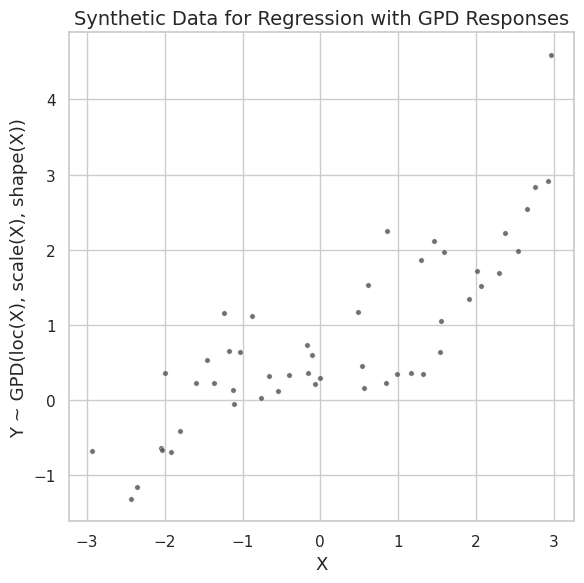

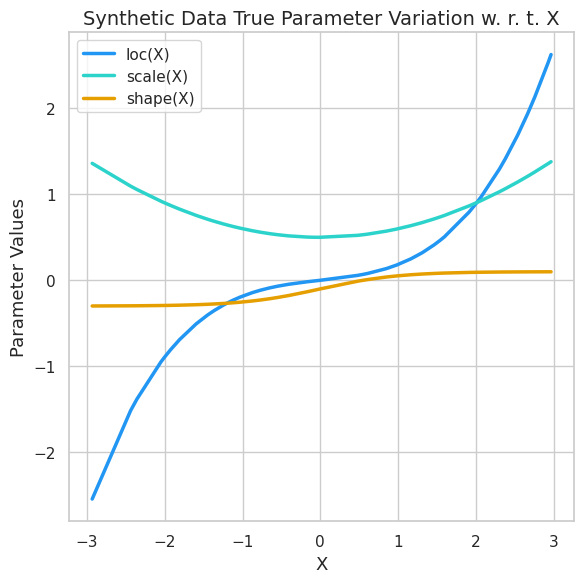

Elapsed time for optimization: 0 min: 25.94 sec
Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_elbo_N50.svg


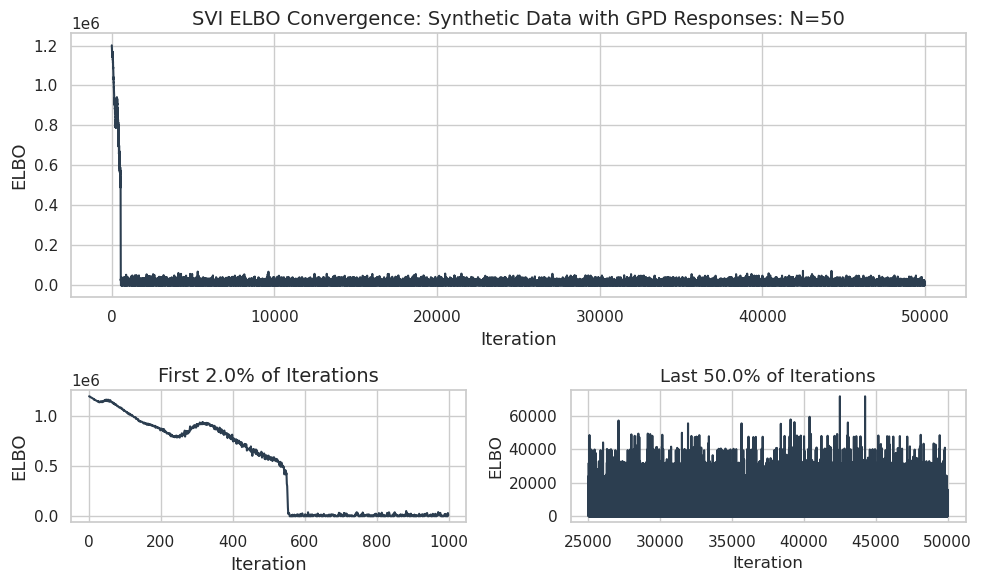

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_regression_results_N50.svg


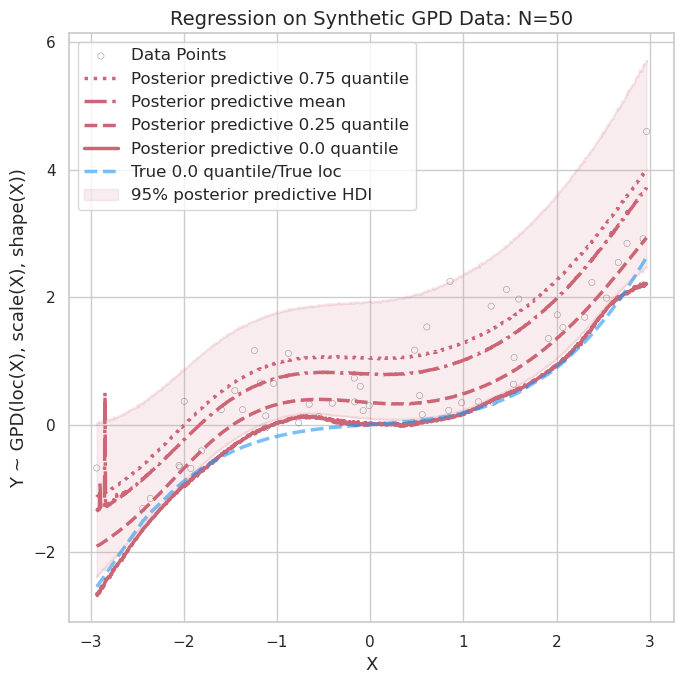

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_true_posterior_comp_N50.svg


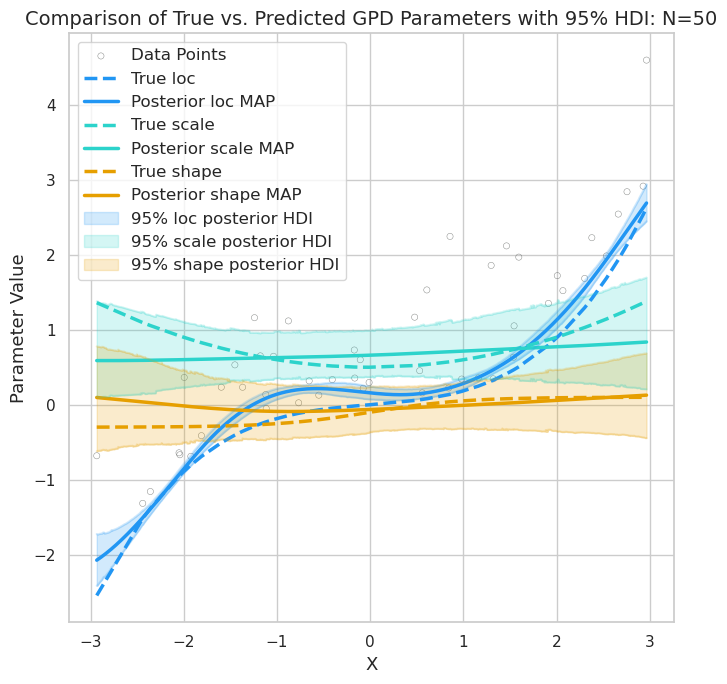

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/single_run_syn_data_prior_predictive_responses.svg


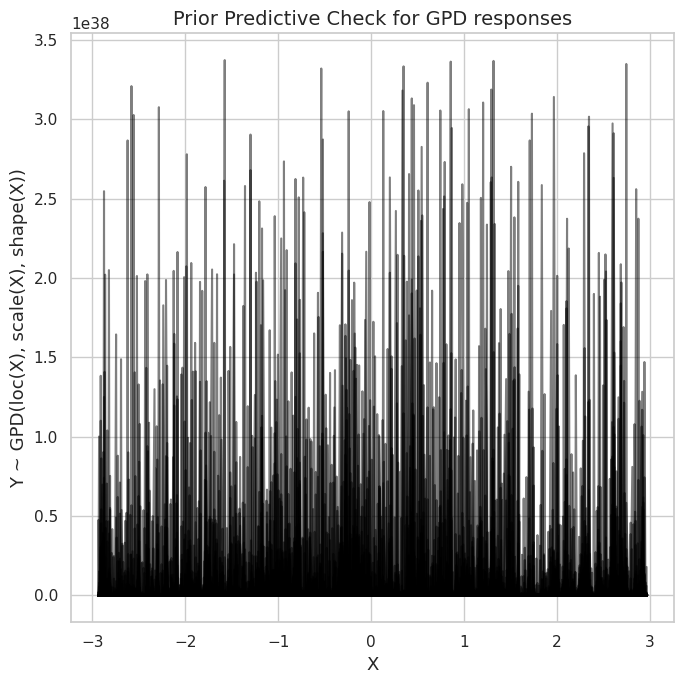

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/single_run_syn_data_prior_predictive_loc.svg


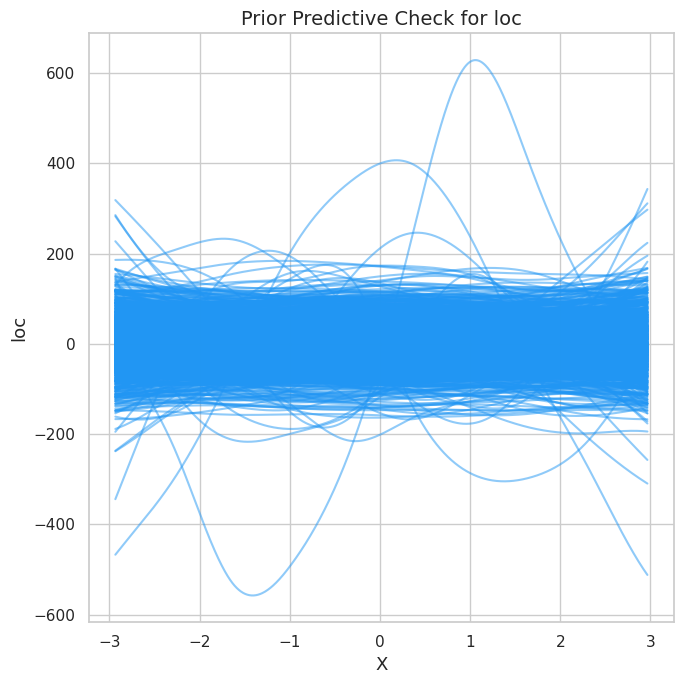

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/single_run_syn_data_prior_predictive_scale.svg


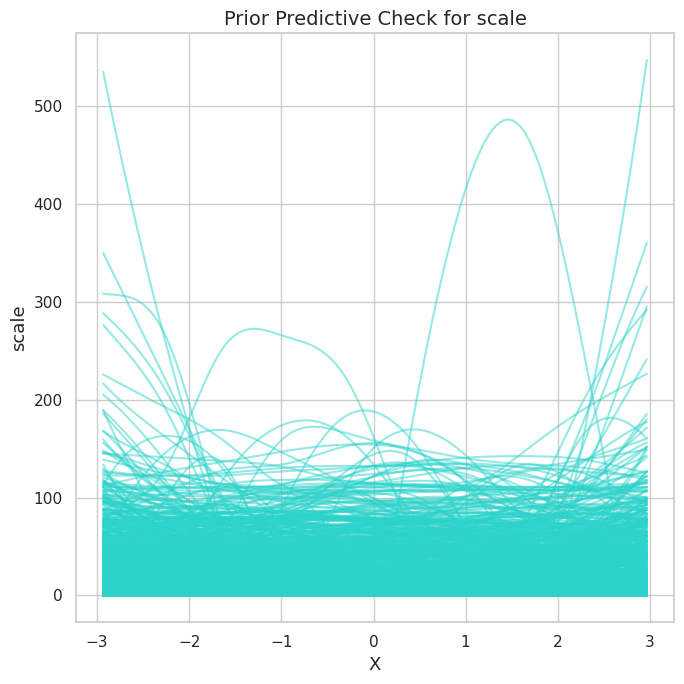

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/single_run_syn_data_prior_predictive_shape.svg


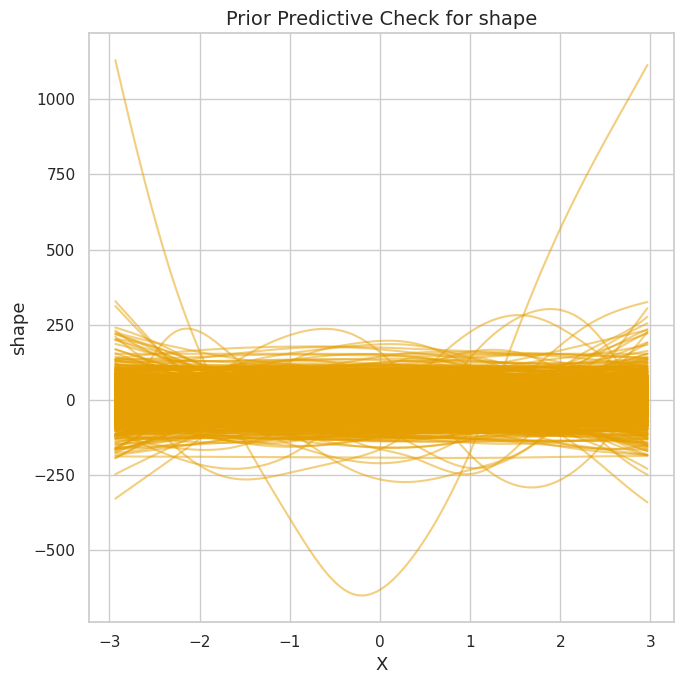

In [10]:
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(
    50, seed_1, enable_plot=True, save_plot=True
)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
results_n50 = vigamlss_gpd_sim_study_opt_run(model, seed_2, epochs=50000)
vigamlss_gpd_sim_study_single_run_results(
    model,
    results_n50,
    knots,
    X_SYN,
    Y_SYN,
    loc_vals,
    scale_vals,
    shape_vals,
    save_plots=True,
    save_priorp=True,
)

#### N=100

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:619: UserWarning: The synthetic_data plots have not been saved. Set do_save=True for saving.
  warnings.warn(


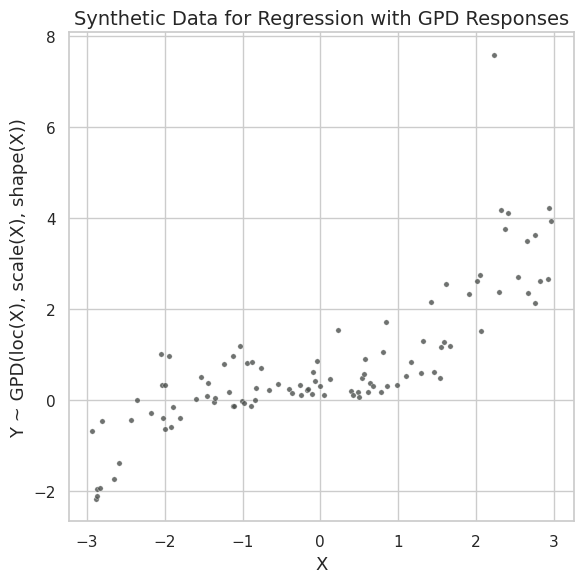

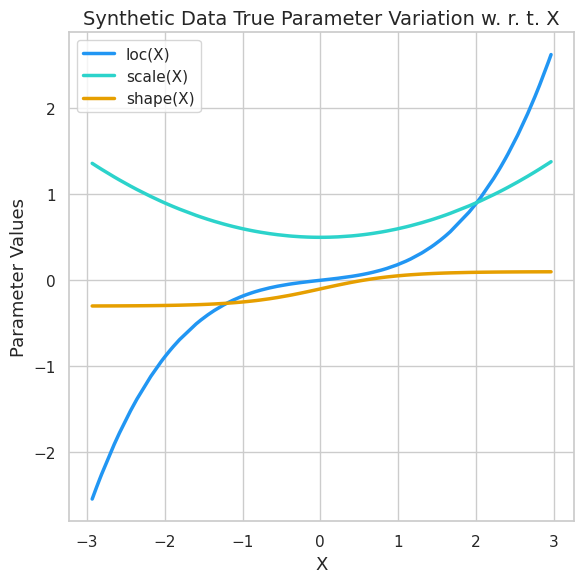

Elapsed time for optimization: 0 min: 25.47 sec
Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_elbo_N100.svg


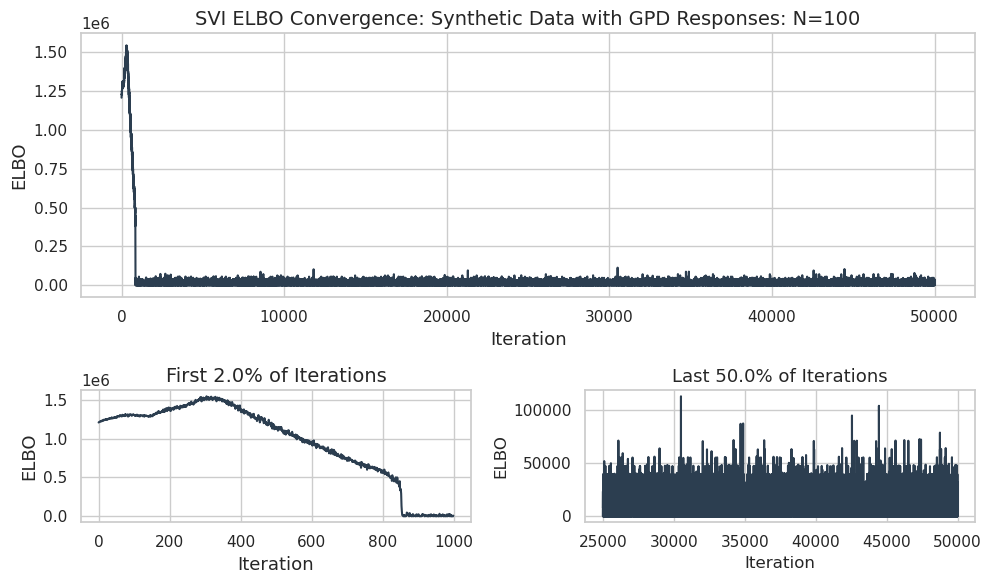

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_regression_results_N100.svg


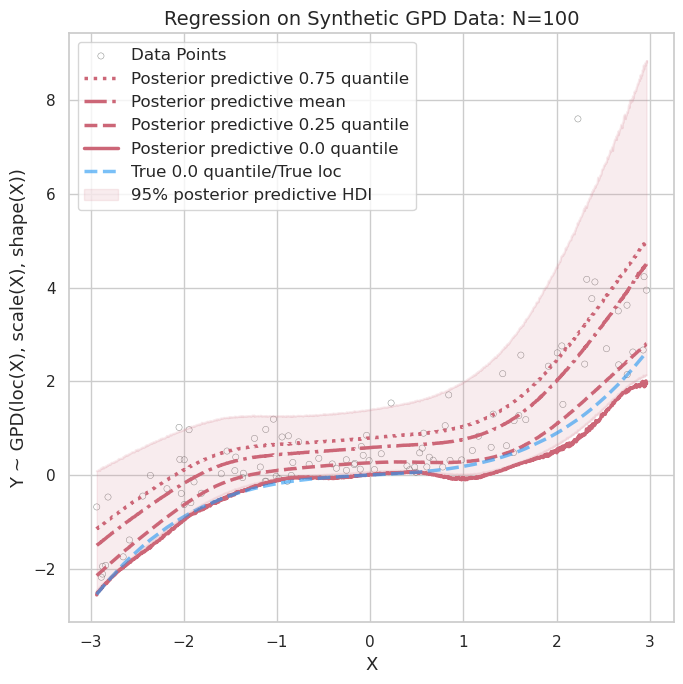

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_true_posterior_comp_N100.svg


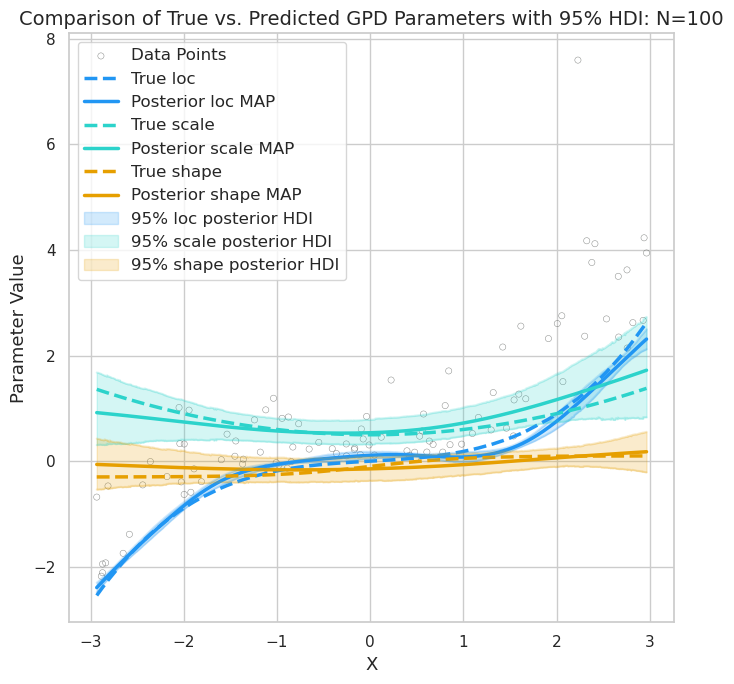

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


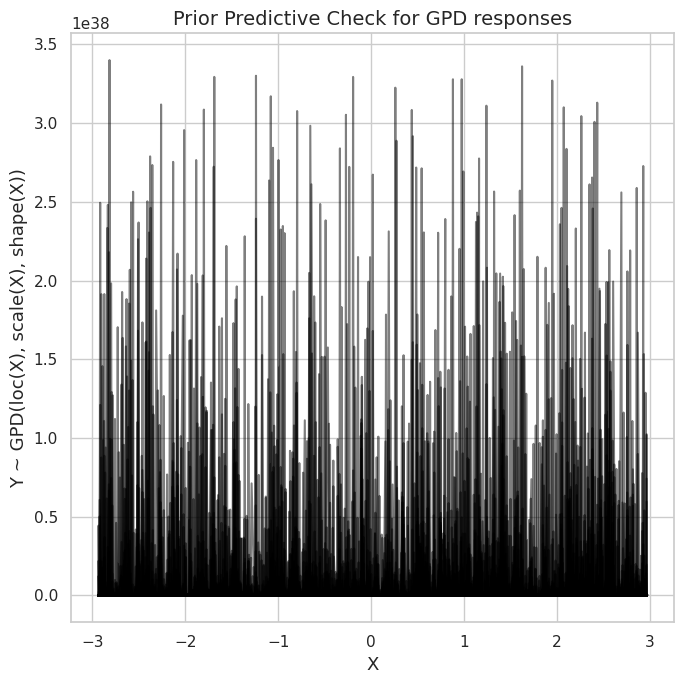

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


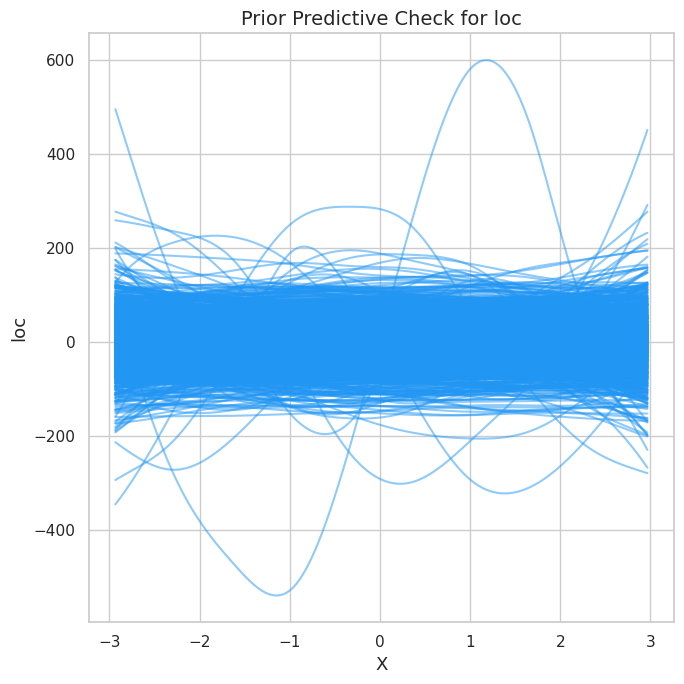

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


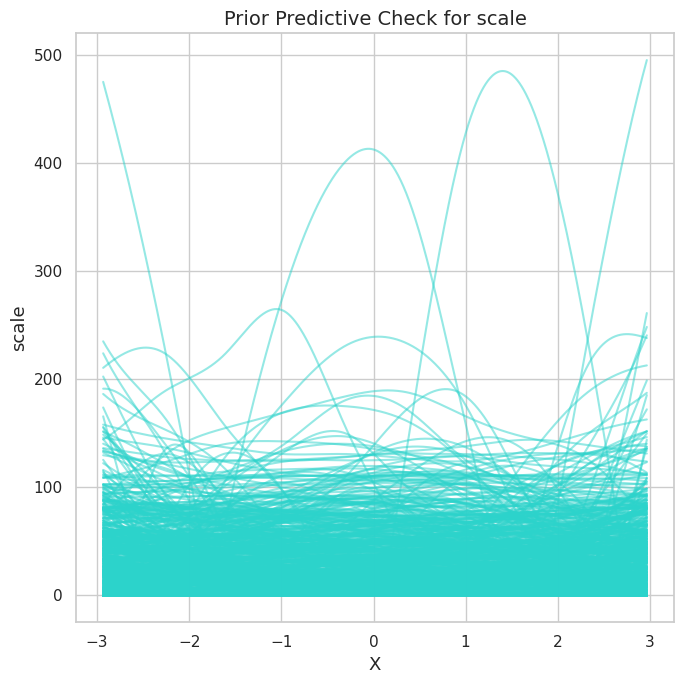

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


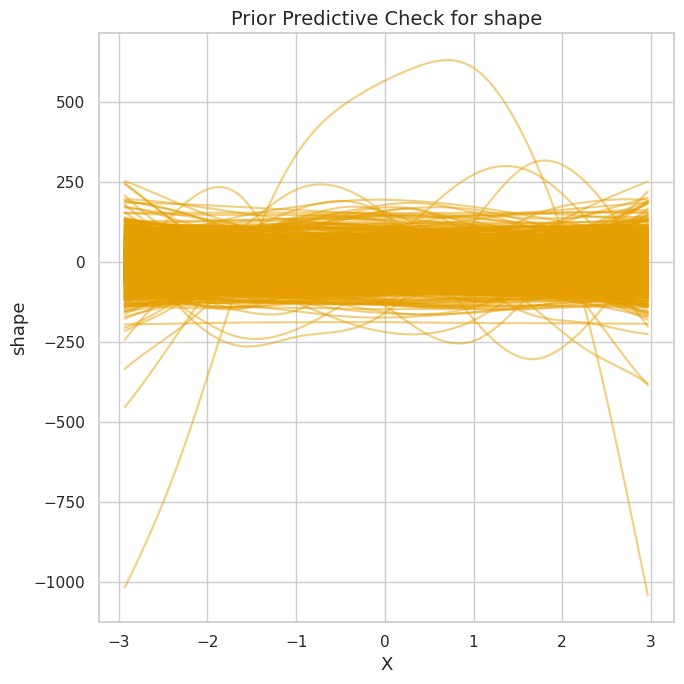

In [11]:
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(100, seed_1)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
results_n100 = vigamlss_gpd_sim_study_opt_run(model, seed_2, epochs=50000)
vigamlss_gpd_sim_study_single_run_results(model, results_n100, knots, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals, save_plots=True)

#### N=500

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:619: UserWarning: The synthetic_data plots have not been saved. Set do_save=True for saving.
  warnings.warn(


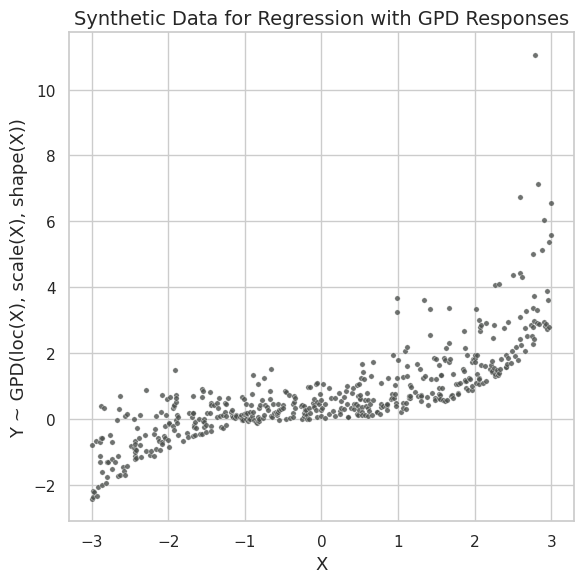

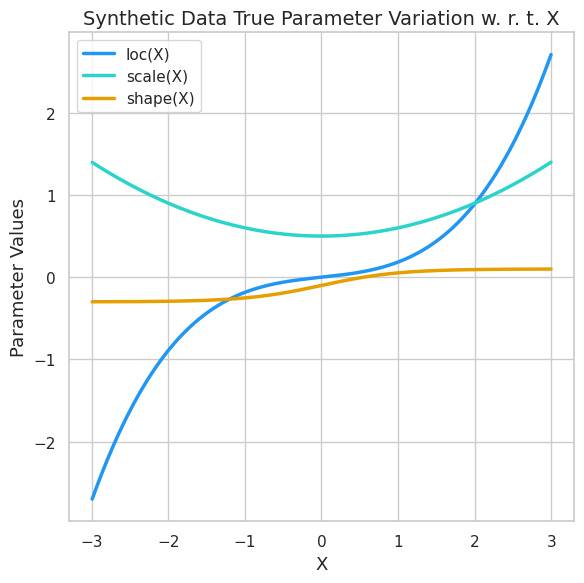

Elapsed time for optimization: 0 min: 28.91 sec
Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_elbo_N500.svg


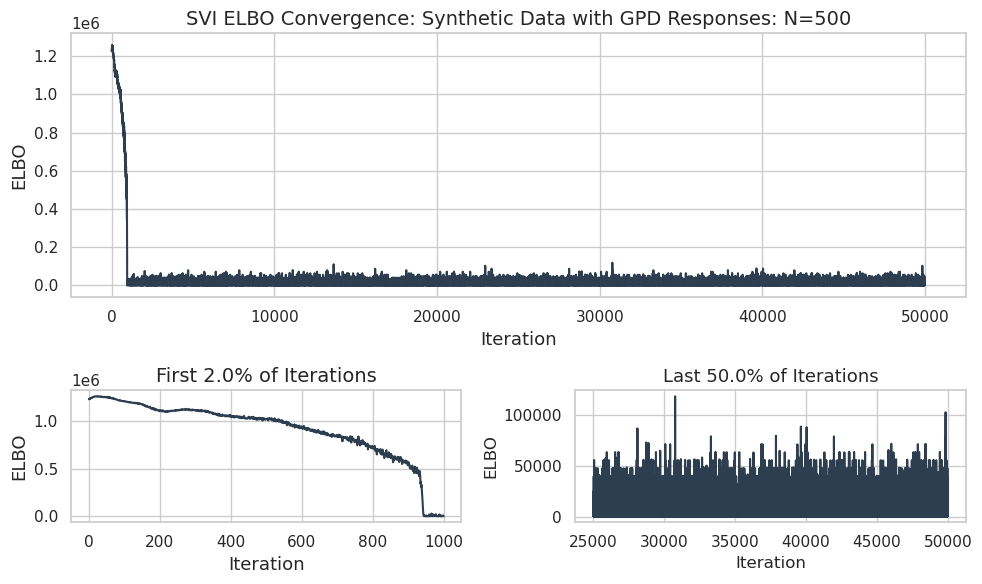

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_regression_results_N500.svg


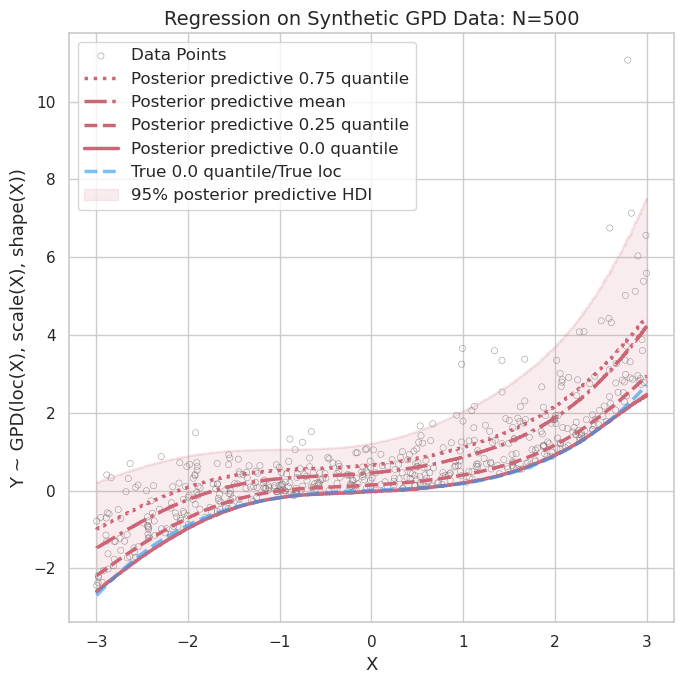

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_true_posterior_comp_N500.svg


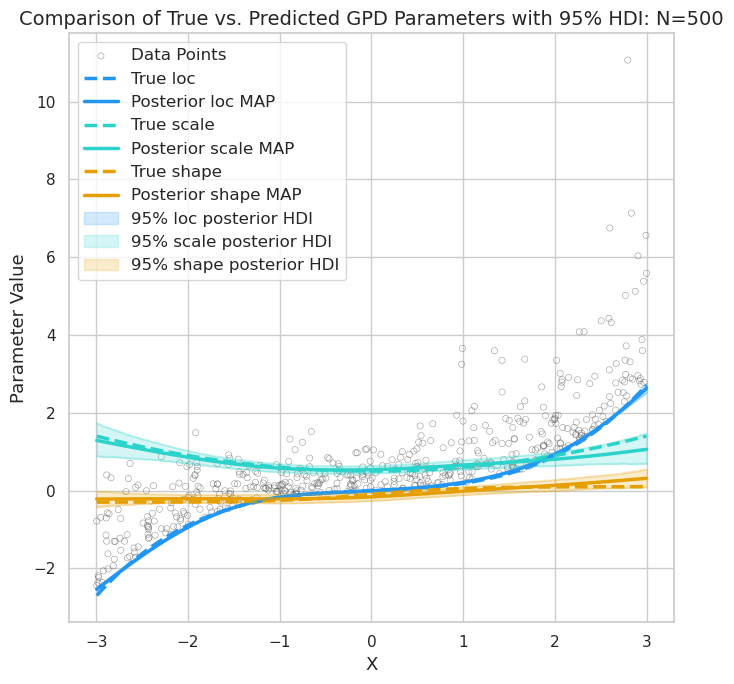

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


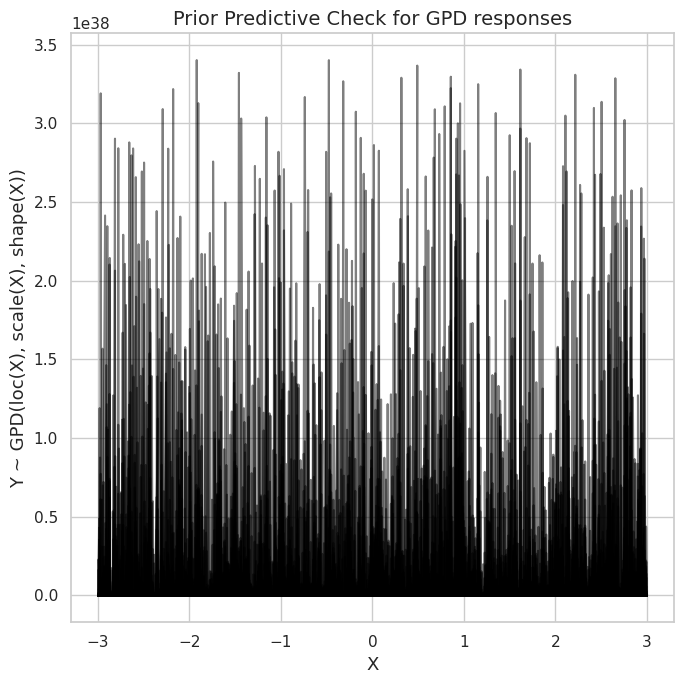

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


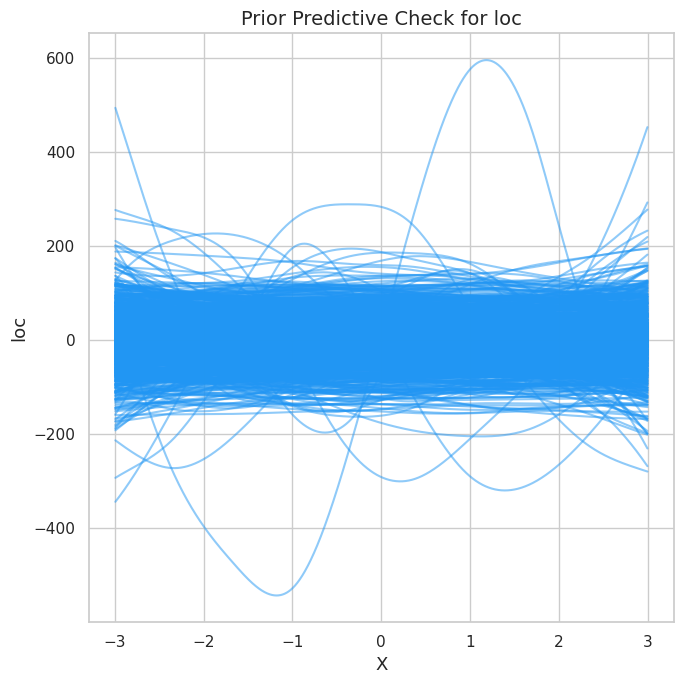

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


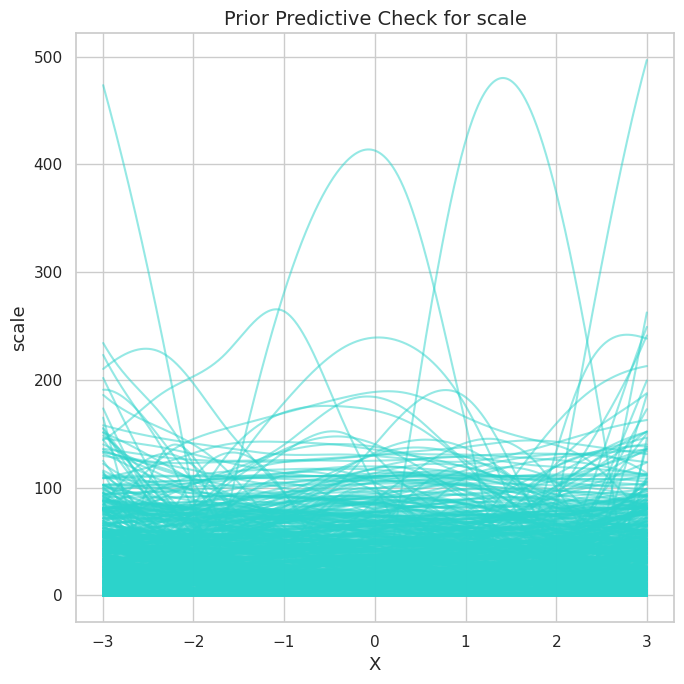

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


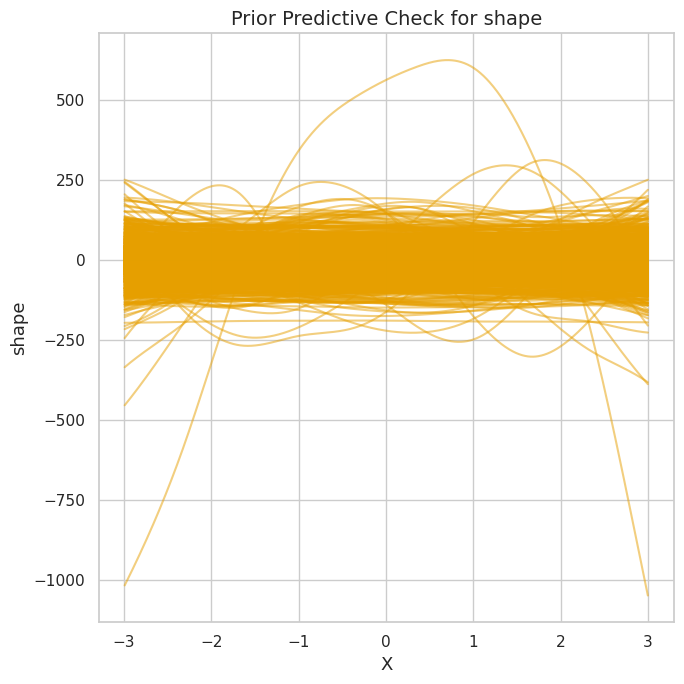

In [12]:
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(500, seed_1)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
results_n500 = vigamlss_gpd_sim_study_opt_run(model, seed_2, epochs=50000)
vigamlss_gpd_sim_study_single_run_results(model, results_n500, knots, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals, save_plots=True)

#### N=1000

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:619: UserWarning: The synthetic_data plots have not been saved. Set do_save=True for saving.
  warnings.warn(


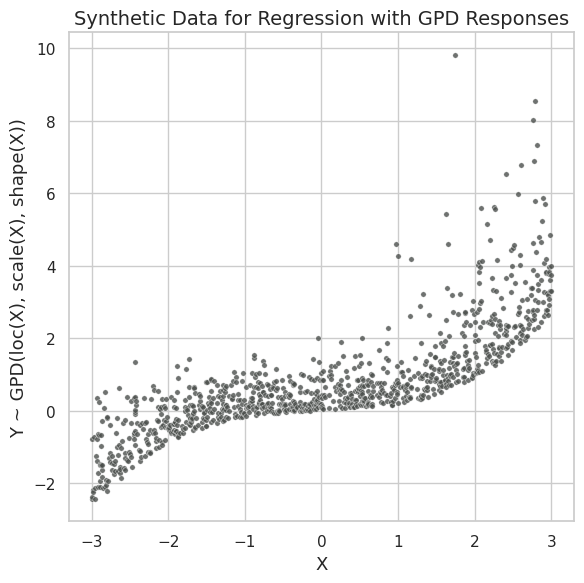

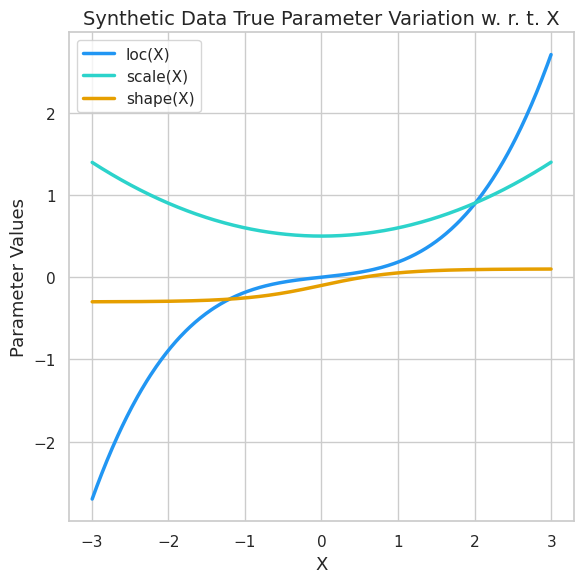

Elapsed time for optimization: 0 min: 29.22 sec
Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_elbo_N1000.svg


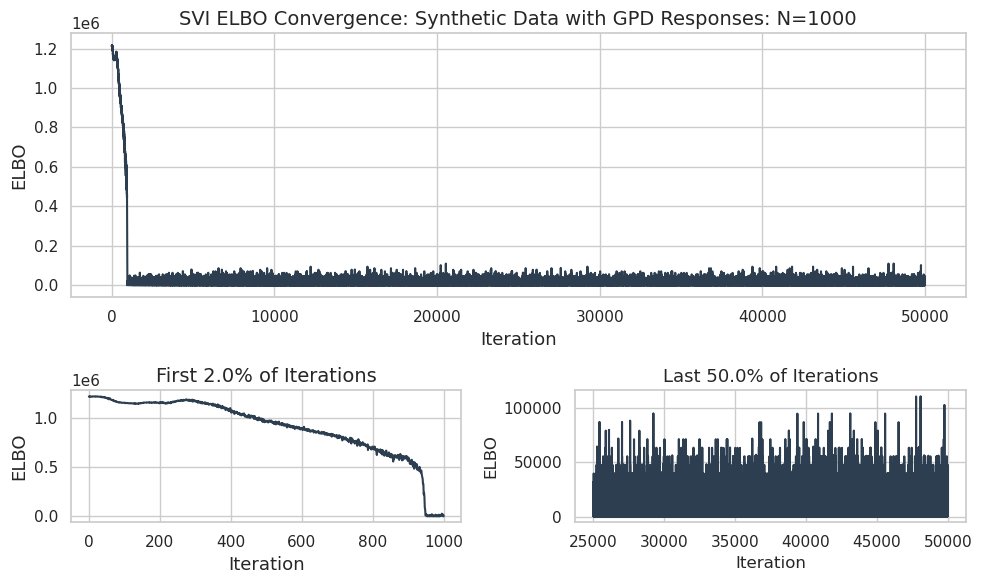

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_regression_results_N1000.svg


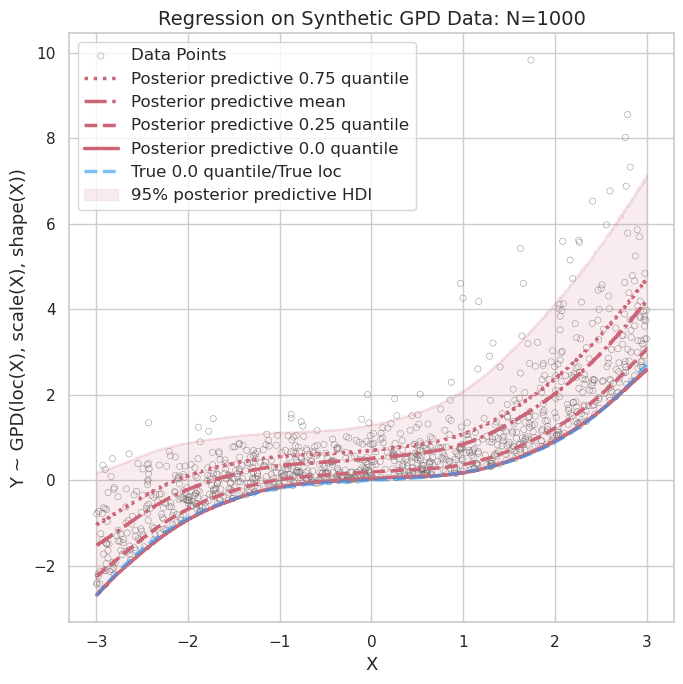

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/sigle_run_syn_data_true_posterior_comp_N1000.svg


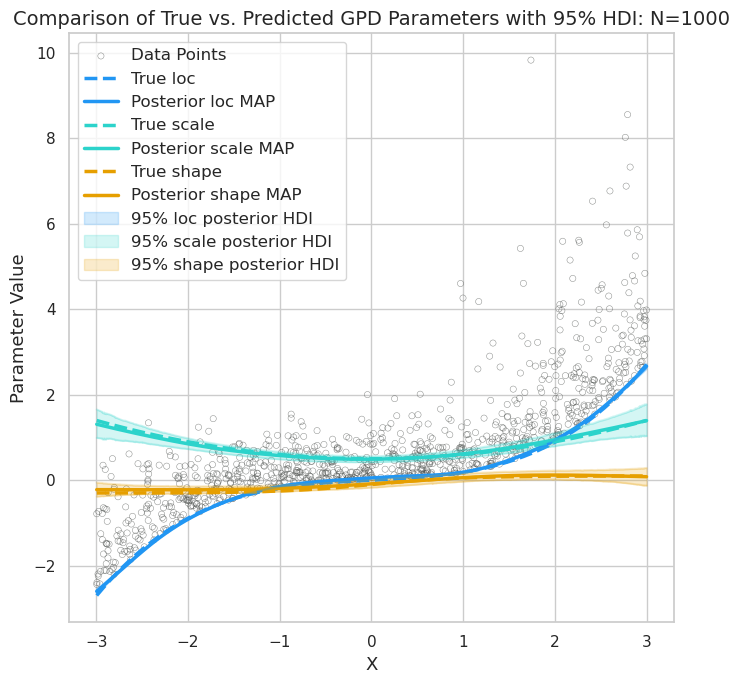

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


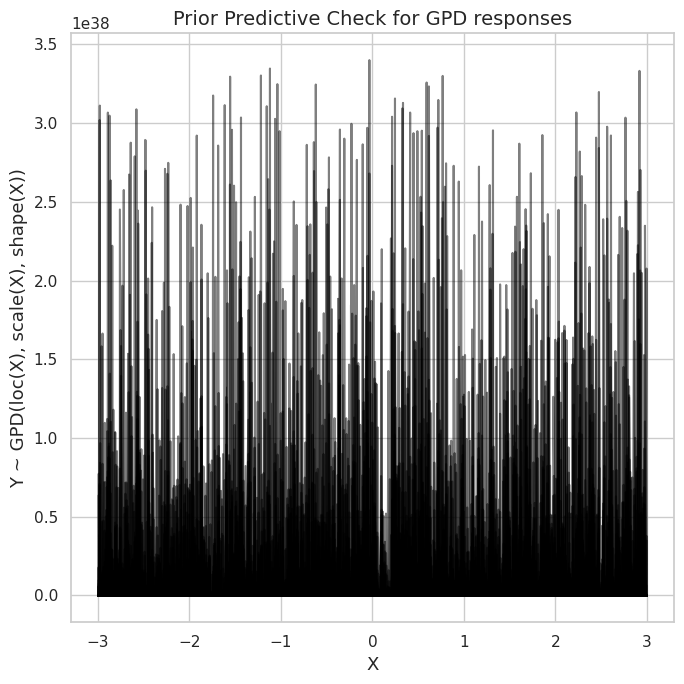

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


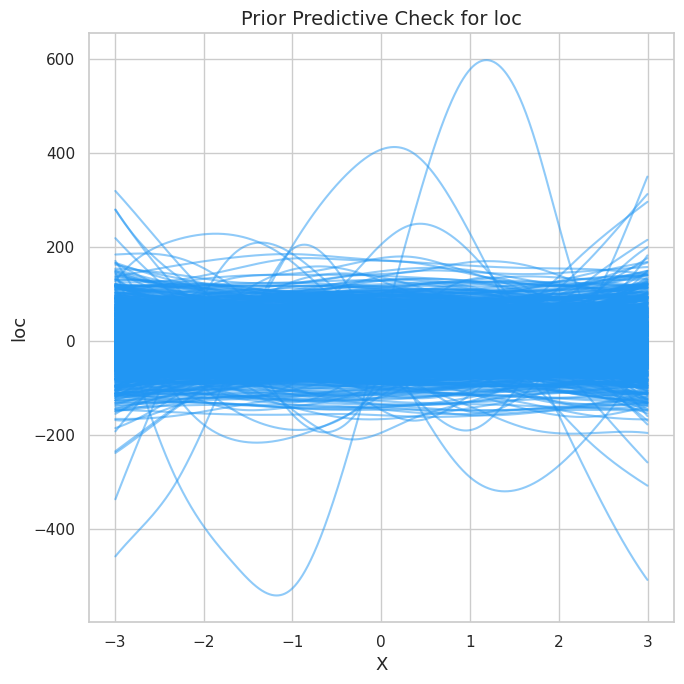

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


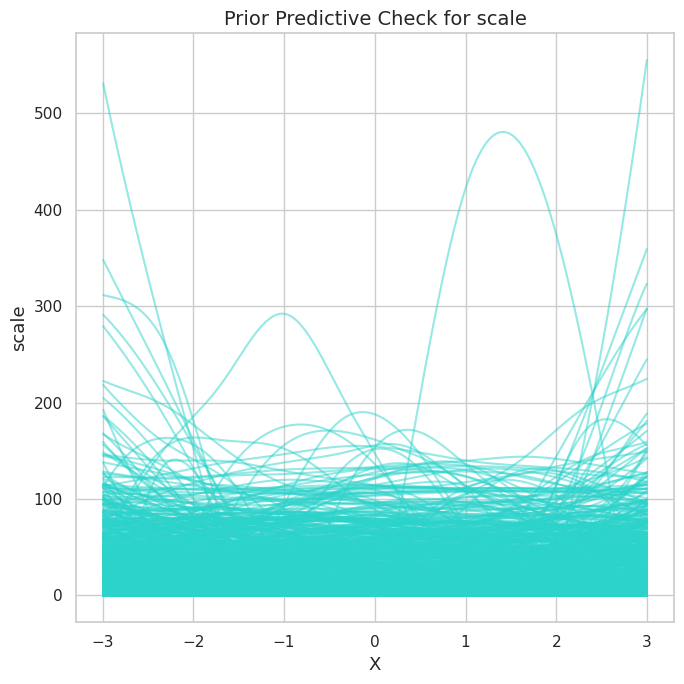

/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:915: UserWarning: The prior predictive plot has not been saved. Flag do_save=True for saving.
  warnings.warn(


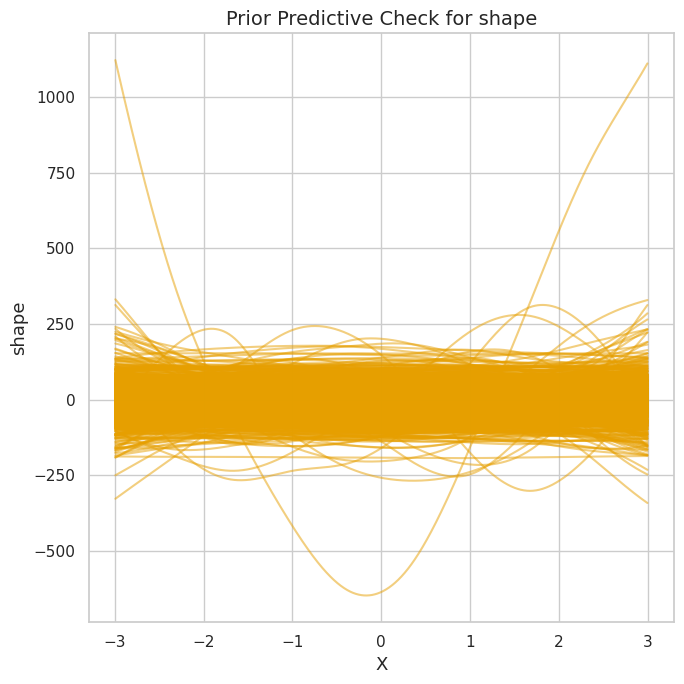

In [13]:
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(1000, seed_1)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
results_n1000 = vigamlss_gpd_sim_study_opt_run(model, seed_2, epochs=50000)
vigamlss_gpd_sim_study_single_run_results(model, results_n1000, knots, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals, save_plots=True)

### SVI Loop

#### Prepare

In [11]:
def sim_study_svi_run_loop(
    n_runs: int, Ns: List[int], epochs: int, save_dir: str, do_run: bool = False
) -> None:
    if do_run:
        for N in tqdm(Ns, desc="N", position=1):
            sim_params_dir_svi_results_N = save_dir + f"/{N}"
            sim_params_dir_svi_results_N_loc = sim_params_dir_svi_results_N + "/loc"
            sim_params_dir_svi_results_N_chol = sim_params_dir_svi_results_N + "/chol"
            for run_i in tqdm(range(n_runs), desc="Run", position=0):
                seed = PRNGKey(run_i)
                seed_1, seed_2 = jax.random.split(seed)
                X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = (
                    vigamlss_gpd_create_syn_data(N, seed_1, enable_plot=False)
                )
                DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
                model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
                results = vigamlss_gpd_sim_study_opt_run(
                    model, seed_2, epochs=epochs, print_time=False
                )
                save_svi_vi_parameters(
                    results,
                    sim_params_dir_svi_results_N_loc,
                    sim_params_dir_svi_results_N_chol,
                    f"svi_run_{run_i}",
                )
    else:
        warnings.warn(
            "The SVI Simulation Study loop has not been run. Flag do_run=True for running loop.",
            category=UserWarning,
        )

#### Conduct SVI MCMC Part

In [9]:
n_runs = 100
Ns=[50,100,500,1000]
epochs=50000
do_run_loop=False
do_run_load=True
do_run_sampling=True
sim_study_svi_run_loop(
    n_runs=n_runs,
    Ns=Ns,
    epochs=epochs,
    save_dir=sim_svi_e25000,
    do_run=do_run_loop,
)
svi_results = sim_study_loading_loop(
    save_dir=sim_params_dir_svi_results,
    do_run=do_run_load,
)
svi_posterior_samples = gather_posterior_samples_nested(svi_results, n_samples=(1000,), device="cpu", do_run=do_run_sampling)

/tmp/ipykernel_652943/2979045433.py:27: UserWarning: The SVI Simulation Study loop has not been run. Flag do_run=True for running loop.
  warnings.warn(


#### Test W. D. and Plotting

In [10]:
reference_test = svi_posterior_samples["E100"]["1000"]["samples"][0]
test_wasserstein_distances = compute_wasserstein_nested(svi_posterior_samples, reference_test, device="gpu", do_run=True)

/home/marcel/miniconda3/envs/masterthesis/lib/python3.11/site-packages/ot/backend.py:1465: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d),
/home/marcel/miniconda3/envs/masterthesis/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: Problem unbounded
  check_result(result_code)


/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:145: UserWarning: The violin plot has not been saved. Flag do_save=True for saving.
  )


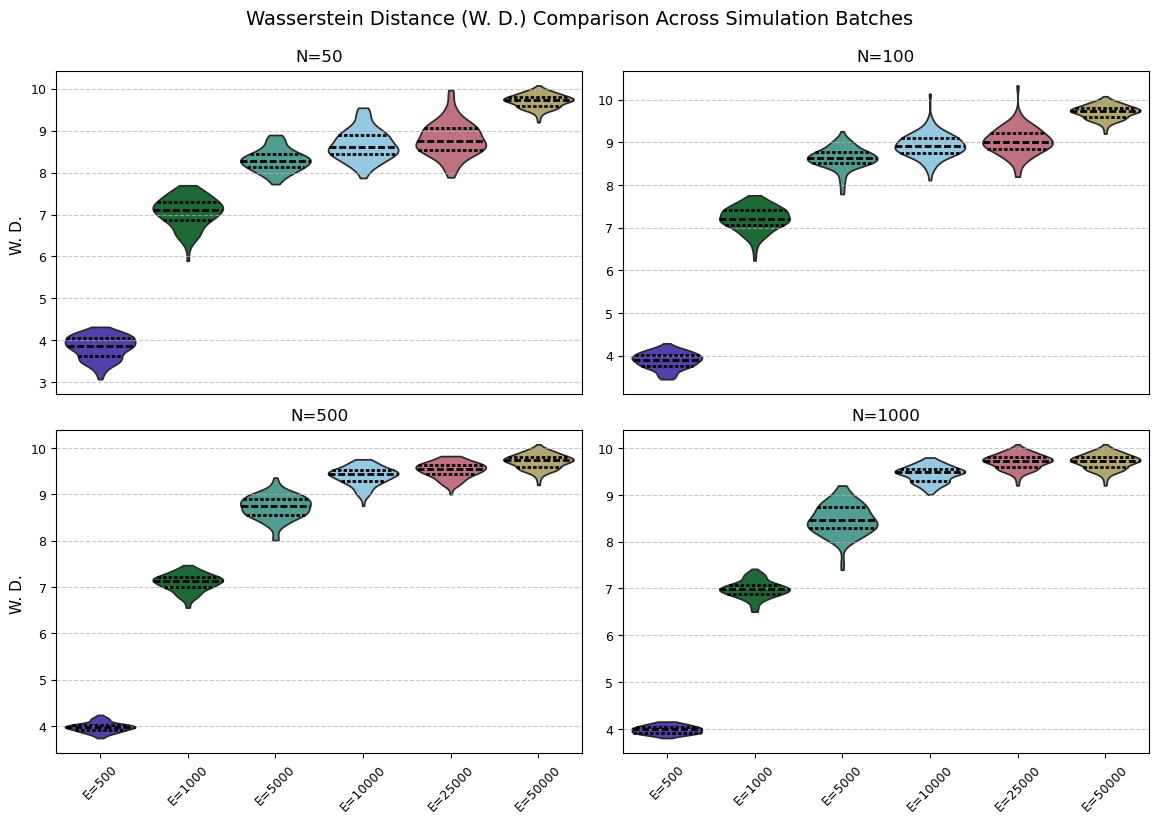

In [30]:
# Create labels and titles
x_labels = ["E=500", "E=1000", "E=5000", "E=10000", "E=25000", "E=50000"]
row_titles = ["N=50", "N=100", "N=500", "N=1000"]
ref_dist = test_wasserstein_distances["E50000"]["1000"]["wassersteindistance"]
main_dists = [
#    test_wasserstein_distances["E100"]["50"]["wassersteindistance"],
#    test_wasserstein_distances["E500"]["50"]["wassersteindistance"],
    test_wasserstein_distances["E1000"]["50"]["wassersteindistance"],
    test_wasserstein_distances["E5000"]["50"]["wassersteindistance"],
    test_wasserstein_distances["E10000"]["50"]["wassersteindistance"],
    test_wasserstein_distances["E25000"]["50"]["wassersteindistance"],
    test_wasserstein_distances["E50000"]["50"]["wassersteindistance"],
 #   test_wasserstein_distances["E100"]["100"]["wassersteindistance"],
#    test_wasserstein_distances["E500"]["100"]["wassersteindistance"],
    test_wasserstein_distances["E1000"]["100"]["wassersteindistance"],
    test_wasserstein_distances["E5000"]["100"]["wassersteindistance"],
    test_wasserstein_distances["E10000"]["100"]["wassersteindistance"],
    test_wasserstein_distances["E25000"]["100"]["wassersteindistance"],
    test_wasserstein_distances["E50000"]["100"]["wassersteindistance"],
#    test_wasserstein_distances["E100"]["500"]["wassersteindistance"],
#    test_wasserstein_distances["E500"]["500"]["wassersteindistance"],
    test_wasserstein_distances["E1000"]["500"]["wassersteindistance"],
    test_wasserstein_distances["E5000"]["500"]["wassersteindistance"],
    test_wasserstein_distances["E10000"]["500"]["wassersteindistance"],
    test_wasserstein_distances["E25000"]["500"]["wassersteindistance"],
    test_wasserstein_distances["E50000"]["500"]["wassersteindistance"],
#    test_wasserstein_distances["E100"]["1000"]["wassersteindistance"],
#    test_wasserstein_distances["E500"]["1000"]["wassersteindistance"],
    test_wasserstein_distances["E1000"]["1000"]["wassersteindistance"],
    test_wasserstein_distances["E5000"]["1000"]["wassersteindistance"],
    test_wasserstein_distances["E10000"]["1000"]["wassersteindistance"],
    test_wasserstein_distances["E25000"]["1000"]["wassersteindistance"],
    test_wasserstein_distances["E50000"]["1000"]["wassersteindistance"],
]

plot_wasserstein_violinplot(
    wasserstein_distances=main_dists,
    reference_wassersteindistances=ref_dist,
    x_labels=x_labels,
    reference_x_label="Reference",
    nrows=4,
    ncols=5,
    palette=COLORBLIND_PALETTE[:5],
    reference_color=COLORBLIND_PALETTE[-1],
    fig_title="Wasserstein Distance (W. D.) Comparison Across Simulation Batches",
    quartiles_color = "black",
    subplot_titles=row_titles,
    y_label="W. D. ",
    title_fontsize=14,
    label_fontsize=11,
    #save_dir="./plots",
    #file_name="wasserstein_grid_comparison.svg",
    do_save=False
)

#### Support Check and Plotting

In [3]:
def sim_study_supportcheck_svi_run(
    n_runs: int, Ns: List[int], epochs_max: int, save_dir: str, do_run: bool = False
) -> None:
    if do_run:
        for N in Ns:
            sim_params_dir_svi_results_N = os.path.join(save_dir, f"{N}")
            for run_i in tqdm(range(n_runs), desc="Runs:"):
                sim_params_dir_svi_results_N_run = os.path.join(
                    sim_params_dir_svi_results_N, f"run_{run_i}"
                )
                sim_params_dir_support_checks = os.path.join(
                    sim_params_dir_svi_results_N_run, "support_checks"
                )
                os.makedirs(sim_params_dir_support_checks, exist_ok=True)

                # Generate data and model once per run
                seed = PRNGKey(run_i)
                seed_1, seed_2 = jax.random.split(seed)
                X_SYN, Y_SYN, _, _, _ = vigamlss_gpd_create_syn_data(
                    N, seed_1, enable_plot=False
                )
                DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
                model = vigamlss_gpd_sim_study_define_model(DesignMatrix, Y_SYN, K)
                results = vigamlss_gpd_sim_study_opt_run(
                    model, seed_2, epochs=epochs_max, print_time=False
                )

                # Prepare static data for scan
                carry = (
                    DesignMatrix.matrix,
                    Y_SYN,
                )
                partial_compute_support_checks = partial(
                    compute_support_checks,
                    split_indices=model.split_indices,
                    transformations=model.transformations,
                    rv_names=model.rv_names,
                )
                jitted_partial_compute_support_checks = jax.jit(
                    partial_compute_support_checks
                )
                # Process all epochs at once with scan
                vi_locs_per_epoch = results["vi_locs"]
                _, means = jax.lax.scan(
                    jitted_partial_compute_support_checks,
                    carry,
                    vi_locs_per_epoch,
                )

                # Save all results as single array
                save_support_checks(
                    jax.device_get(means), sim_params_dir_support_checks, "all_epochs"
                )
    else:
        warnings.warn(
            "Execution skipped for running Support Check run: do_run=False", UserWarning
        )

/tmp/ipykernel_193372/2771675937.py:55: UserWarning: Execution skipped for running Support Check run: do_run=False
  warnings.warn(
/home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/scripts/notebook_utils/plotting.py:1063: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if do_save and save_dir:


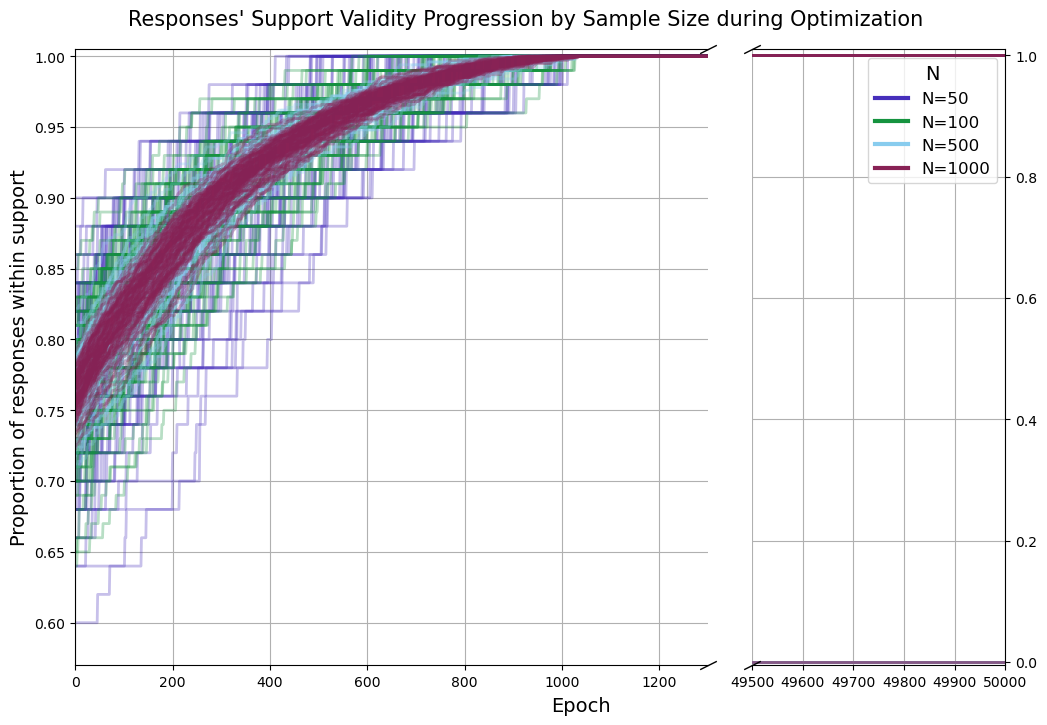

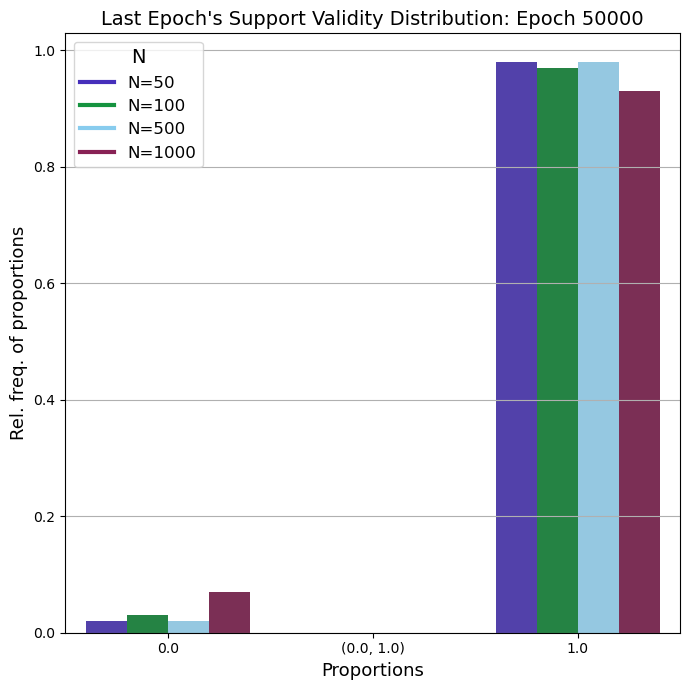

In [9]:
do_run_supportcheck_loop = False
do_run_load_supportcheck = True
sim_study_supportcheck_svi_run(
    100,
    [50, 100, 500, 1000],
    50000,
    sim_svi_supportcheck_dir,
    do_run=do_run_supportcheck_loop,
)
supportcheck_means = supportcheck_loading_loop(
    sim_svi_supportcheck_dir, do_run=do_run_load_supportcheck
)
plot_support_checks_lineplot(
    support_data_dict=supportcheck_means,
    Ns=[50, 100, 500, 1000],
    epochs_max=50000,
    colorpalette=[
        COLORBLIND_PALETTE[0],
        COLORBLIND_PALETTE[1],
        COLORBLIND_PALETTE[3],
        COLORBLIND_PALETTE[6],
    ],
    do_save=True,
    save_dir=plot_dir_sim,
)
plot_support_checks_histogram(
    support_data_dict=supportcheck_means,
    Ns=[50, 100, 500, 1000],
    epochs_max=50000,
    colorpalette=[
        COLORBLIND_PALETTE[0],
        COLORBLIND_PALETTE[1],
        COLORBLIND_PALETTE[3],
        COLORBLIND_PALETTE[6],
    ],
    do_save=True,
    save_dir=plot_dir_sim,
    figsize=(7,7),
)

#### Perform NUTS MCMC Runs

In [ ]:
# Helper function to set up each model component (location, scale, shape)
def setup_component(name, K, beta0_prior_scale, lambda_prior_scale):
    # Beta0 parameter (Normal prior)
    beta0 = lsl.param(
        jnp.array([0.0]),
        distribution=lsl.Dist(tfd.Normal, loc=0.0, scale=beta0_prior_scale),
        name=f"beta0_{name}"
    )
    
    # Lambda parameter (HalfCauchy prior)
    lambda_ = lsl.param(
        jnp.array([1.0]),
        distribution=lsl.Dist(tfd.HalfCauchy, loc=0.0, scale=lambda_prior_scale),
        name=f"lambda_{name}"
    )
    
    # Gamma's penalty matrix and distribution (DegenerateNormal)
    penalty = lsl.obs(K, name=f"gamma_{name}_penalty")
    evals = jnp.linalg.eigvalsh(K)
    rank = lsl.Data(jnp.sum(evals > 0.0), _name=f"gamma_{name}_rank")
    log_pdet = lsl.Data(jnp.sum(jnp.log(jnp.where(evals > 0.0, evals, 1.0))), _name=f"gamma_{name}_log_pdet")
    
    gamma_dist = lsl.Dist(
        MultivariateNormalDegenerate.from_penalty,
        loc=0.0,
        var=lambda_,
        pen=penalty,
        rank=rank,
        log_pdet=log_pdet
    )
    gamma = lsl.param(
        jnp.zeros(K.shape[1]),
        distribution=gamma_dist,
        name=f"gamma_{name}"
    )
    
    return beta0, lambda_, gamma

# Data
seed = PRNGKey(1)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(
    50, seed_1, enable_plot=False, save_plot=False
)
DesignMatrix, K, knots = vigamlss_gpd_sim_study_prepare_data(X_SYN)
# Assuming DesignMatrix, K_loc, K_scale, K_shape, and Y_SYN are predefined
# Setup components for location, scale, and shape
beta0_loc, lambda_loc, gamma_loc = setup_component("loc", K, 10.0, 0.01)
beta0_scale, lambda_scale, gamma_scale = setup_component("scale", K, 10.0, 0.01)
beta0_shape, lambda_shape, gamma_shape = setup_component("shape", K, 10.0, 0.01)

# Design matrix (observed variable)

design_matrix = lsl.obs(DesignMatrix.matrix, name="design_matrix")

# Linear predictors for each parameter
linear_predictor_loc = lsl.Calc(
    lambda beta0_loc, gamma_loc, design_matrix: beta0_loc + design_matrix @ gamma_loc,
    beta0_loc=beta0_loc, gamma_loc=gamma_loc, design_matrix=design_matrix,
    #name="linear_predictor_loc"
)
transformed_linear_predictor_scale = lsl.Calc(
    lambda beta0_scale, gamma_scale, design_matrix: jax.nn.softplus(beta0_scale + design_matrix @ gamma_scale),
    beta0_scale=beta0_scale, gamma_scale=gamma_scale, design_matrix=design_matrix,
    #name="linear_predictor_scale"
)
linear_predictor_shape = lsl.Calc(
    lambda beta0_shape, gamma_shape, design_matrix: beta0_shape + design_matrix @ gamma_shape,
    beta0_shape=beta0_shape, gamma_shape=gamma_shape, design_matrix=design_matrix,
    #name="linear_predictor_shape"
)
loc = lsl.Var(linear_predictor_loc, name="linear_predictor_loc")
scale = lsl.Var(transformed_linear_predictor_scale, name="transformed_linear_predictor_scale")
shape = lsl.Var(linear_predictor_shape, name="linear_predictor_shape")

# GPD response distribution
y_dist = lsl.Dist(
    tfd.GeneralizedPareto,
    loc=loc,
    scale=scale,
    concentration=shape
)
Y = lsl.Var(Y_SYN, distribution=y_dist, name="Y")

# Build the model graph
gb = lsl.GraphBuilder().add(Y)


model = gb.build_model()

# # Configure MCMC with NUTS
# builder = gs.EngineBuilder(seed=42, num_chains=4)
# builder.set_model(gs.LieselInterface(model))
# builder.set_initial_values(model.state)

# Disable jittering for variance (lambda) and regression (gamma) parameters
builder = lsl.dist_reg_mcmc(
    model,
    seed=42,
    num_chains=4,
    tau2_jitter_fn=lambda key, val: val,    # Identity function for variance params
    beta_jitter_fn=lambda key, val: val     # Identity function for regression params
)

# Parameters to sample (transformed lambdas and others)
position_keys = [
    "beta0_loc", "lambda_loc", "gamma_loc",
    "beta0_scale", "lambda_scale", "gamma_scale",
    "beta0_shape", "lambda_shape", "gamma_shape"
]

builder.add_kernel(gs.NUTSKernel(position_keys))
builder.set_duration(warmup_duration=4000, posterior_duration=1000)

engine = builder.build()

# Run MCMC sampling
engine.sample_all_epochs()

# Retrieve and inspect results
results = engine.get_results()
summary = gs.Summary(results)
print(summary)

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'beta0_loc', 'lambda_loc', 'gamma_loc', 'beta0_scale', 'lambda_scale', 'gamma_scale', 'beta0_shape', 'lambda_shape', 'gamma_shape'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:17<00:00,  5.91s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13.01chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 25, 25, 25, 25 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.

                      var_fqn     kernel var_index  sample_size      mean  \
variable                                                                    
beta0_loc        beta0_loc[0]  kernel_00      (0,)         4000  0.721171   
beta0_scale    beta0_scale[0]  kernel_00      (0,)         4000 -0.176868   
beta0_shape    beta0_shape[0]  kernel_00      (0,)         4000  0.259299   
gamma_loc        gamma_loc[0]  kernel_00      (0,)         4000 -0.085542   
gamma_loc        gamma_loc[1]  kernel_00      (1,)         4000  0.042236   
gamma_loc        gamma_loc[2]  kernel_00      (2,)         4000  0.065458   
gamma_loc        gamma_loc[3]  kernel_00      (3,)         4000  0.068610   
gamma_loc        gamma_loc[4]  kernel_00      (4,)         4000 -0.003785   
gamma_loc        gamma_loc[5]  kernel_00      (5,)         4000 -0.033221   
gamma_loc        gamma_loc[6]  kernel_00      (6,)         4000 -0.004718   
gamma_loc        gamma_loc[7]  kernel_00      (7,)         4000  0.041790   

# VIGAMLSS for DBBMI

## Build Bayesian Quantile Regression Model

### Prepare

In [3]:
def vigamlss_dbbmi_prepare_qr_data():
    dbbmi_df = pd.read_csv("../data/dbbmi_data.csv")
    X = dbbmi_df["age"].values
    Y = dbbmi_df["bmi"].values
    X = jnp.array(X)
    Y = jnp.array(Y)
    sort_indices = jnp.argsort(X)
    X = X[sort_indices]
    Y = Y[sort_indices]
    DesignMatrix, K, knots = DataPreparator(
        "dbbmi DesignMatrix",
        X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        use_quantile=True,
        return_knots=True,
    )()
    return DesignMatrix, X, Y, K, knots


def vigamlss_dbbmi_qr_define_model(DesignMatrix, Y, K, tau=0.97):
    β0_loc = Normal("beta0_loc", jnp.array([0.0]), jnp.array([50.0]), 1)
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.01]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)

    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([50.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.01]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    Y = ALD(
        rv_name="y_GPD",
        loc=β0_loc + DesignMatrix @ γ_loc,
        scale=β0_scale + DesignMatrix @ γ_scale,
        tau=tau,
        responses=Y,
    )
    return Y.model, tau


def vigamlss_dbbmi_qr_opt_run(model, epochs):
    results = model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=epochs,
        mb_size=None,
        lr=0.01,
        max_norm=1.0,
        clip_min_max_enabled=False,
        zero_nans_enabled=False,
        prng_key=PRNGKey(0),
        scheduler_type="warmup_cosine_decay",
        warmup_fraction=0.01,
        end_value=1e-4,
        init_value=1e-5,
    )
    return results


def vigamlss_dbbmi_qr_results(
    results_QR, model_QR, knots_QR, X, Y, tau, save_flag=True
):
    β0_loc_opt = results_QR["transformed_loc_vi_parameters"]["beta0_loc"]
    γ_loc_opt = results_QR["transformed_loc_vi_parameters"]["gammas_loc"]
    # -----------------------------------------------------------------
    # The following in order to sample β0_loc & γ_loc from the joint posterior
    # to create a HDI
    split_indices = model_QR.split_indices
    transformations = model_QR.transformations
    rv_names = model_QR.rv_names
    dict_loc_vi_parameters_samples = sample_from_vi_posterior(
        results_QR["loc_vi_parameters_vec"],
        results_QR["chol_vi_vec"],
        transformations,
        split_indices,
        rv_names,
        15000,
        "gpu",
    )
    β0_loc_samples = dict_loc_vi_parameters_samples["beta0_loc"]
    γ_loc_samples = dict_loc_vi_parameters_samples["gammas_loc"]

    # For Threshold Prediction
    # 1) Collect indices
    num_lin_space = 1000
    lin_part = jnp.linspace(X.min(), X.max(), num_lin_space)
    posterior_X_unsorted = jnp.concatenate([lin_part, X])
    indices = jnp.arange(num_lin_space + len(X))

    # 2) Sort combined array
    sorted_order = jnp.argsort(posterior_X_unsorted)
    posterior_X_sorted = posterior_X_unsorted[sorted_order]

    # 3) Keep track of posterior_X indices
    sorted_posterior_X_idx = indices[sorted_order]

    # 4) Which sorted positions correspond to X vs. linspace?
    mask_X = sorted_posterior_X_idx >= num_lin_space
    where_sample_X = jnp.where(mask_X)[0]

    posterior_DesignMatrix, _ = DataPreparator(
        "pred DesignMatrix",
        posterior_X_sorted,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        user_knots=knots_QR,
    )()

    posterior_thresholds_map = β0_loc_opt + posterior_DesignMatrix.matrix @ γ_loc_opt
    with jax.default_device(jax.devices("gpu")[0]):
        posterior_thresholds_map_samples = (
            β0_loc_samples + γ_loc_samples @ posterior_DesignMatrix.matrix.T
        )
    posterior_thresholds_map_samples = np.array(posterior_thresholds_map_samples)

    estimated_posterior_threshold_hdi_bounds = az.hdi(
        posterior_thresholds_map_samples, hdi_prob=0.95
    )
    posterior_threshold_hdi_lower = estimated_posterior_threshold_hdi_bounds[:, 0]
    posterior_threshold_hdi_upper = estimated_posterior_threshold_hdi_bounds[:, 1]

    # -----------------------------------------------------------------
    # Compute peaks over threshold, i. e. the excesses
    diff = Y - posterior_thresholds_map[where_sample_X]
    excess_mask = diff > 0
    Y_excess = diff[excess_mask]
    X_excess = X[excess_mask]

    plot_data(
        X=X,
        Y=Y,
        scatterplot_color=SCATTERPLOT_COLOR,
        scatter_xlabel="Age",
        scatter_ylabel="BMI",
        scatter_title="BMI vs. Age: Dutch Boys BMI Dataset",
        file_name="dbbmi_scatterplot",
        save_dir=plot_dir_case_study_ald,
        do_save=save_flag,
    )
    plot_elbo(
        num_iterations=results_QR["svi_metadata"]["num_iterations"],
        title="SVI ELBO Convergence: Synthetic Data with ALD Responses: DBBMI Case Study",
        elbo_values=results_QR["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.06,
        final_percentage=0.94,
        save_dir=plot_dir_case_study_ald,
        file_name="dbbmi_qr_elbo",
        apply_ma=(False, False, True),
        window=500,
        tick_label_plain=[False, False, True],
        do_save=save_flag,
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        marker=".",
        scatter_size=60,
        line_xs=[posterior_X_sorted],
        line_xs_hdi=[posterior_X_sorted],
        regression_lines=[posterior_thresholds_map],
        hdi_lower_bounds=[posterior_threshold_hdi_lower],
        hdi_upper_bounds=[posterior_threshold_hdi_upper],
        hdi_alphas=[0.2],
        regression_line_colors=[QUANTILE_COLOR],
        regression_line_styles=["-"],
        line_alphas=[1.0],
        hdi_colors=[QUANTILE_HDI_COLOR],
        hdi_labels=["95% loc posterior HDI"],
        scatter_color=SCATTERPLOT_COLOR,
        scatter_label="Below Threshold Data Points",
        regression_line_labels=[f"{tau} Quantile Regression Line/ALD loc MAP"],
        x_label="Age",
        y_label="BMI",
        title=f"ALD Quantile Regression of BMI on Age: {tau} Quantile",
        fig_size=(12, 7),
        file_name="case_study_ald_regression_results",
        save_dir=plot_dir_case_study_ald,
        excess_mask=excess_mask,
        excess_color=EXCESS_COLOR,
        do_save=save_flag,
    )
    return (
        Y_excess,
        X_excess,
        excess_mask,
        posterior_X_sorted,
        mask_X,
        posterior_thresholds_map,
        posterior_threshold_hdi_lower,
        posterior_threshold_hdi_upper,
    )


def vigamlss_dbbmi_prepare_gpd_data(X_excess):
    DesignMatrix, K, knots = DataPreparator(
        "dbbmi DesignMatrix",
        X_excess,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        use_quantile=True,
        return_knots=True,
    )()
    return DesignMatrix, K, knots


def vigamlss_dbbmi_cgpd_define_model(DesignMatrix, Y, K):
    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([50.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.01]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    β0_shape = Normal("beta0_shape", jnp.array([0.0]), jnp.array([50.0]), 1)
    λ_shape = HalfCauchy("lambda_shape", jnp.array([0.01]), 1)
    γ_shape = DegenerateNormal("gammas_shape", K, λ_shape)

    Y = CenteredGPD(
        "y_GPD",
        β0_scale + DesignMatrix @ γ_scale,
        β0_shape + DesignMatrix @ γ_shape,
        responses=Y,
    )
    return Y.model


def vigamlss_dbbmi_cgpd_opt_run(model, epochs):
    results = model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=epochs,
        mb_size=None,
        lr=0.001,
        max_norm=1.0,
        clip_min_max_enabled=True,
        zero_nans_enabled=True,
        prng_key=PRNGKey(0),
        scheduler_type="constant",
    )
    return results


def vigamlss_dbbmi_cgpd_results(
    results_CGPD,
    model,
    X,
    Y,
    X_excess,
    Y_excess,
    knots,
    tau,
    excess_mask,
    posterior_X,
    mask_X,
    posterior_thresholds_map,
    posterior_threshold_hdi_lower,
    posterior_threshold_hdi_upper,
    save_flag,
    save_priorp = True,
):
    X_excess_min, X_excess_max = X_excess.min(), X_excess.max()
    front_tail_length = int(jnp.sum(posterior_X < X_excess_min))
    back_tail_length = int(jnp.sum(posterior_X > X_excess_max))
    posterior_X_filtered = posterior_X[
        front_tail_length : len(posterior_X) - back_tail_length
    ]
    posterior_thresholds_map_filtered = np.array(
        posterior_thresholds_map[
            front_tail_length : len(posterior_thresholds_map) - back_tail_length
        ]
    )
    mask_X_filtered = mask_X[front_tail_length : len(mask_X) - back_tail_length]

    # Compute indices of original X points within [X_excess_min, X_excess_max]
    original_X_in_filtered = (X >= X_excess_min) & (X <= X_excess_max)
    original_X_indices = jnp.nonzero(original_X_in_filtered)[0]
    
    # Subset excess_mask to these indices
    subset_excess_mask = excess_mask[original_X_indices]

    excess_DesignMatrix, K = DataPreparator(
        "xDesign",
        posterior_X_filtered,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
        user_knots=knots,
    )()
    split_indices = model.split_indices
    transformations = model.transformations
    rv_names = model.rv_names
    num_samples = 15000
    dict_loc_vi_parameters_samples = sample_from_vi_posterior(
        results_CGPD["loc_vi_parameters_vec"],
        results_CGPD["chol_vi_vec"],
        transformations,
        split_indices,
        rv_names,
        num_samples,
        "gpu",
    )
    β0_scale_samples = dict_loc_vi_parameters_samples["beta0_scale"]
    γ_scale_samples = dict_loc_vi_parameters_samples["gammas_scale"]
    β0_shape_samples = dict_loc_vi_parameters_samples["beta0_shape"]
    γ_shape_samples = dict_loc_vi_parameters_samples["gammas_shape"]
    posterior_scale_samples, posterior_shape_samples = (
        compute_cgpd_loc_scale_shape_posterior_samples(
            β0_scale_samples,
            γ_scale_samples,
            β0_shape_samples,
            γ_shape_samples,
            excess_DesignMatrix.matrix,
            "gpu",
        )
    )
    pp_stats = compute_cgpd_post_predictive_stats(
        posterior_thresholds_map_filtered,
        posterior_scale_samples,
        posterior_shape_samples,
        1,
        PRNGKey(0),
        # device="cpu",
    )

    posterior_predictive_mean = np.array(pp_stats["mean"])
    posterior_predictive_00_quantile = np.array(pp_stats["0.0_quantile"])
    posterior_predictive_075_quantile = np.array(pp_stats["0.75_quantile"])
    posterior_predictive_025_quantile = np.array(pp_stats["0.25_quantile"])
    posterior_predictive_lower_hdi = pp_stats["hdi"][:, 0]
    posterior_predictive_upper_hdi = pp_stats["hdi"][:, 1]

    posterior_scale_samples = np.array(posterior_scale_samples)
    posterior_shape_samples = np.array(posterior_shape_samples)

    posterior_hdi_bounds_scale = az.hdi(posterior_scale_samples, hdi_prob=0.95)
    posterior_hdi_lower_scale = posterior_hdi_bounds_scale[:, 0]
    posterior_hdi_upper_scale = posterior_hdi_bounds_scale[:, 1]
    posterior_hdi_bounds_shape = az.hdi(posterior_shape_samples, hdi_prob=0.95)
    posterior_hdi_lower_shape = posterior_hdi_bounds_shape[:, 0]
    posterior_hdi_upper_shape = posterior_hdi_bounds_shape[:, 1]

    β0_scale_opt = results_CGPD["transformed_loc_vi_parameters"]["beta0_scale"]
    γ_scale_opt = results_CGPD["transformed_loc_vi_parameters"]["gammas_scale"]
    β0_shape_opt = results_CGPD["transformed_loc_vi_parameters"]["beta0_shape"]
    γ_shape_opt = results_CGPD["transformed_loc_vi_parameters"]["gammas_shape"]

    linear_predictor_scale_map = TransformationFunctions.softplus(
        β0_scale_opt + excess_DesignMatrix.matrix @ γ_scale_opt
    )
    linear_predictor_shape_map = β0_shape_opt + excess_DesignMatrix.matrix @ γ_shape_opt

    priorp_stats = compute_prior_predictive_stats_case_study(excess_DesignMatrix.matrix, K, 1000, PRNGKey(0))
    priorp_responses = priorp_stats["response"]
    priorp_loc = priorp_stats["loc"]
    priorp_scale = priorp_stats["scale"]
    priorp_shape = priorp_stats["shape"]

    plot_elbo(
        num_iterations=results_CGPD["svi_metadata"]["num_iterations"],
        title="SVI ELBO Convergence: Synthetic Data with Zero-Centered GPD Responses: DBBMI Case Study",
        elbo_values=results_CGPD["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.006,
        final_percentage=0.994,
        save_dir=plot_dir_case_study_gpd,
        file_name="cgpd_ddbi_elbo",
        do_save=save_flag,
    )
    plot_gpd_qq_plot(
        linear_predictor_scale_map[mask_X_filtered][subset_excess_mask],
        linear_predictor_shape_map[mask_X_filtered][subset_excess_mask],
        Y_excess,
        QQ_SCATTER_LINE_COLOR,
        QQ_SCATTER_QUANTILES_COLOR,
        file_name="dbbmi_qq_plot",
        save_dir=plot_dir_case_study_gpd,
        do_save=save_flag,
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        marker=".",
        scatter_size=60,
        line_xs=[
            posterior_X,
            posterior_X_filtered,
            posterior_X_filtered,
            posterior_X_filtered,
        ],
        line_xs_hdi=[posterior_X, posterior_X_filtered],
        regression_line_styles=["-", "--", "-.", ":"],
        line_alphas=[1.0, 1.0, 1.0, 1.0],
        regression_lines=[
            posterior_thresholds_map,
            posterior_predictive_mean,
            posterior_predictive_075_quantile,
            posterior_predictive_025_quantile,
        ],
        hdi_lower_bounds=[
            posterior_threshold_hdi_lower,
            posterior_predictive_lower_hdi,
        ],
        hdi_upper_bounds=[
            posterior_threshold_hdi_upper,
            posterior_predictive_upper_hdi,
        ],
        hdi_alphas=[0.2, 0.15],
        regression_line_colors=[
            QUANTILE_COLOR,
            GPD_MEAN_COLOR,
            GPD_MEAN_COLOR,
            GPD_MEAN_COLOR,
        ],
        hdi_colors=[QUANTILE_HDI_COLOR, GPD_MEAN_HDI_COLOR],
        hdi_labels=["95% ALD loc posterior HDI", "95% posterior predictive HDI"],
        scatter_color=SCATTERPLOT_COLOR,
        scatter_label="Below Threshold Data Points",
        regression_line_labels=[
            f"{tau} Quantile Regression Line/ALD loc MAP",
            "Posterior predictive 0.75 quantile",
            "Posterior predictive mean",
            "Posterior predictive 0.25 quantile",
        ],
        x_label="Age",
        y_label="BMI",
        title=f"Peak-over-Threshold GPD Regression of BMI on Age",
        fig_size=(12, 7),
        file_name="case_study_cgpd_regression_results",
        save_dir=plot_dir_case_study_ald,
        excess_mask=excess_mask,
        excess_color=EXCESS_COLOR,
        posterior_param_x=posterior_X_filtered,
        posterior_param_lines=[linear_predictor_scale_map, linear_predictor_shape_map],
        posterior_param_line_colors=[GPD_SCALE_COLOR, GPD_SHAPE_COLOR],
        posterior_param_x_label="Age",
        posterior_param_y_label="Parameter Values",
        posterior_param_line_labels=["scale posterior MAP", "shape posterior MAP"],
        posterior_param_titles=[
            "Posterior GPD scale w. r. t. Age",
            "Posterior GPD shape w. r. t. Age",
        ],
        posterior_param_hdis_lower=[
            posterior_hdi_lower_scale,
            posterior_hdi_lower_shape,
        ],
        posterior_param_hdis_upper=[
            posterior_hdi_upper_scale,
            posterior_hdi_upper_shape,
        ],
        posterior_param_hdi_alphas=[0.2, 0.2],
        posterior_param_hdi_labels=[
            "95% scale posterior HDI",
            "95% shape posterior HDI",
        ],
        posterior_param_hdi_colors=[GPD_SCALE_COLOR, GPD_SHAPE_COLOR],
        posterior_fig_size=(12, 3),
        y_origin=16,
        do_save=save_flag,
    )
    prior_predictive_plot(
        line_x=posterior_X_filtered,
        y_list=priorp_responses,
        x_label="X",
        y_label="Y ~ GPD(loc(X), scale(X), shape(X))",
        title=f"Prior Predictive Check for GPD responses",
        alpha=0.5,
        color="black",
        fig_size=(7,7),
        file_name=f"single_run_dbbi_data_prior_predictive_responses",
        save_dir=plot_dir_sim,
        do_save=save_priorp,
    )
    prior_predictive_plot(
        line_x=posterior_X_filtered,
        y_list=priorp_loc,
        x_label="X",
        y_label="loc",
        title=f"Prior Predictive Check for loc",
        alpha=0.5,
        color=GPD_LOC_COLOR,
        fig_size=(7,7),
        file_name=f"single_run_dbbi_data_prior_predictive_loc",
        save_dir=plot_dir_sim,
        do_save=save_priorp,
    )
    prior_predictive_plot(
        line_x=posterior_X_filtered,
        y_list=priorp_scale,
        x_label="X",
        y_label="scale",
        title=f"Prior Predictive Check for scale",
        alpha=0.5,
        color=GPD_SCALE_COLOR,
        fig_size=(7,7),
        file_name=f"single_run_dbbi_data_prior_predictive_scale",
        save_dir=plot_dir_sim,
        do_save=save_priorp,
    )
    prior_predictive_plot(
        line_x=posterior_X_filtered,
        y_list=priorp_shape,
        x_label="X",
        y_label="shape",
        title=f"Prior Predictive Check for shape",
        alpha=0.5,
        color=GPD_SHAPE_COLOR,
        fig_size=(7,7),
        file_name=f"single_run_dbbi_data_prior_predictive_shape",
        save_dir=plot_dir_sim,
        do_save=save_priorp,
    )

### Conduct

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/dbbmi_scatterplot.svg
Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/dbbmi_scatterplot.svg


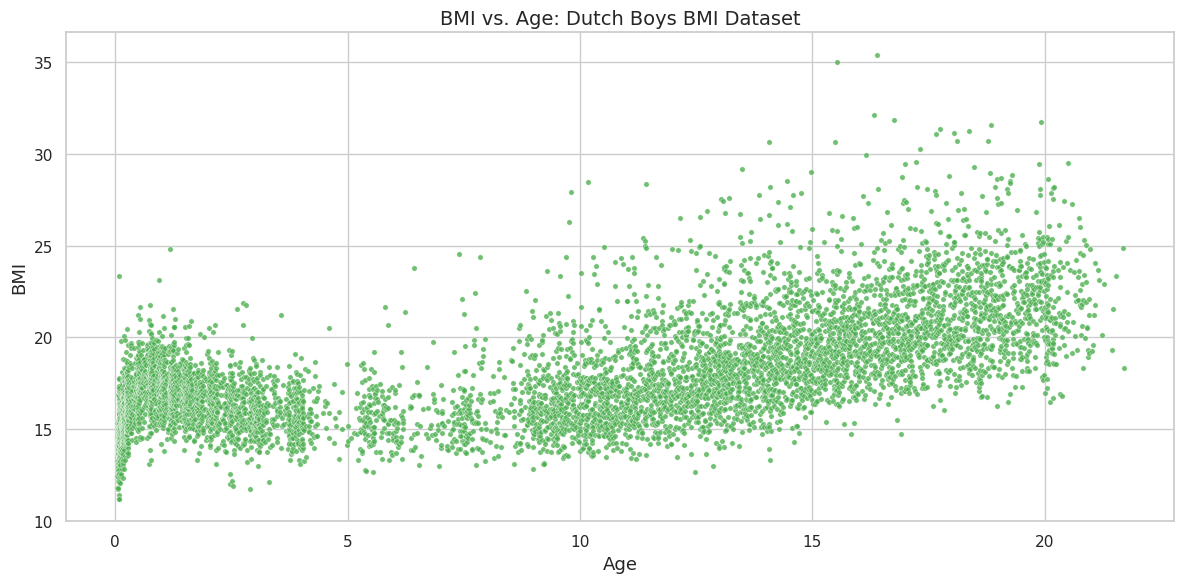

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/dbbmi_qr_elbo.svg


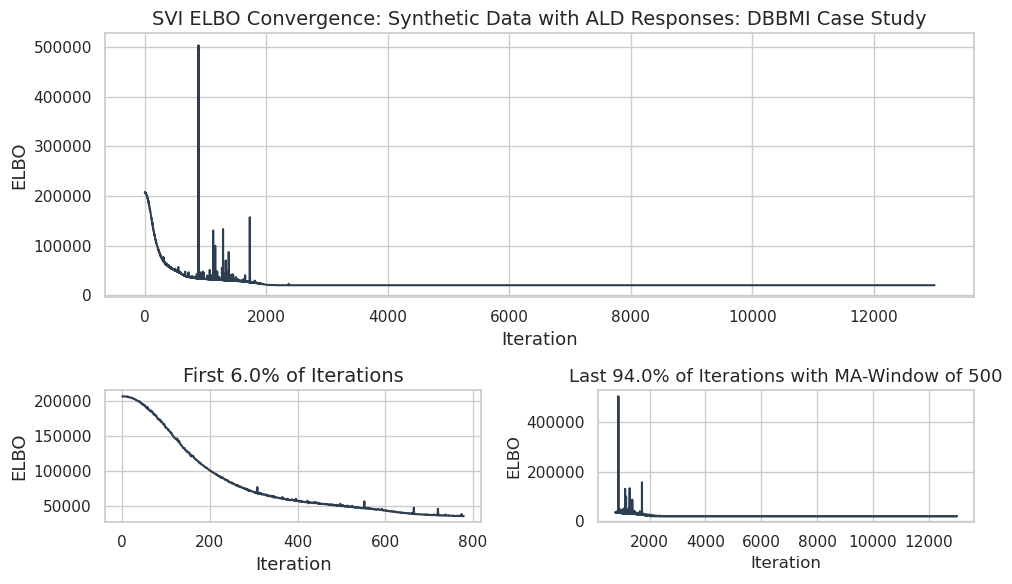

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/case_study_ald_regression_results.svg


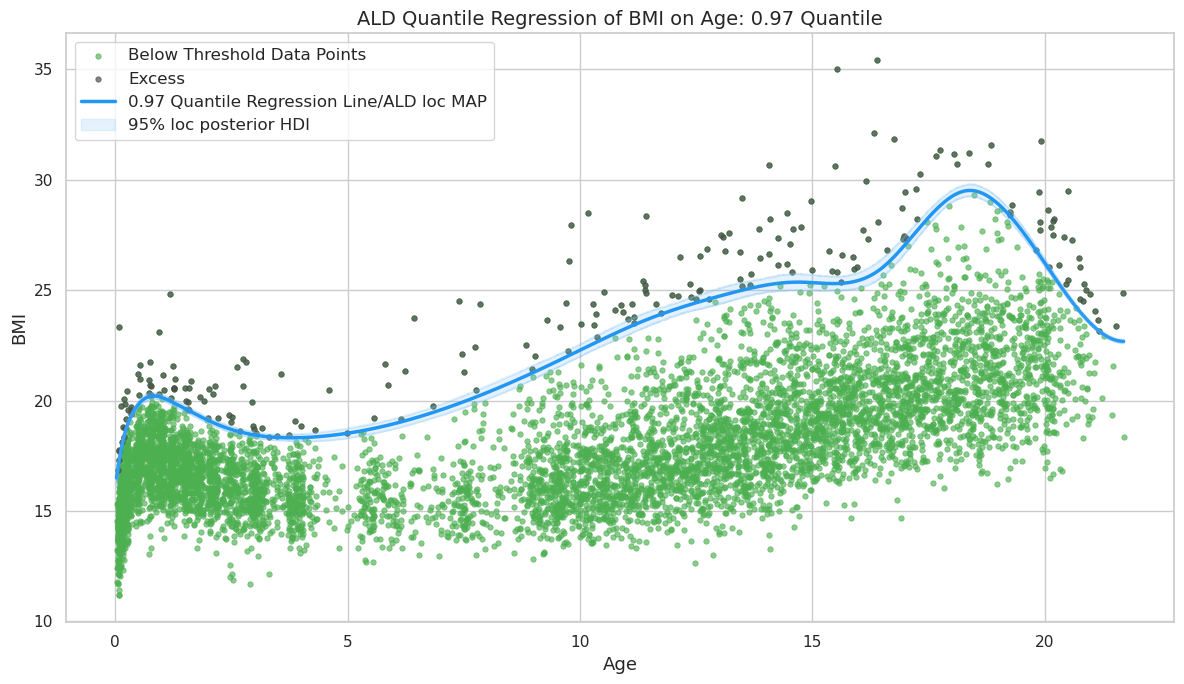

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/gpd/cgpd_ddbi_elbo.svg


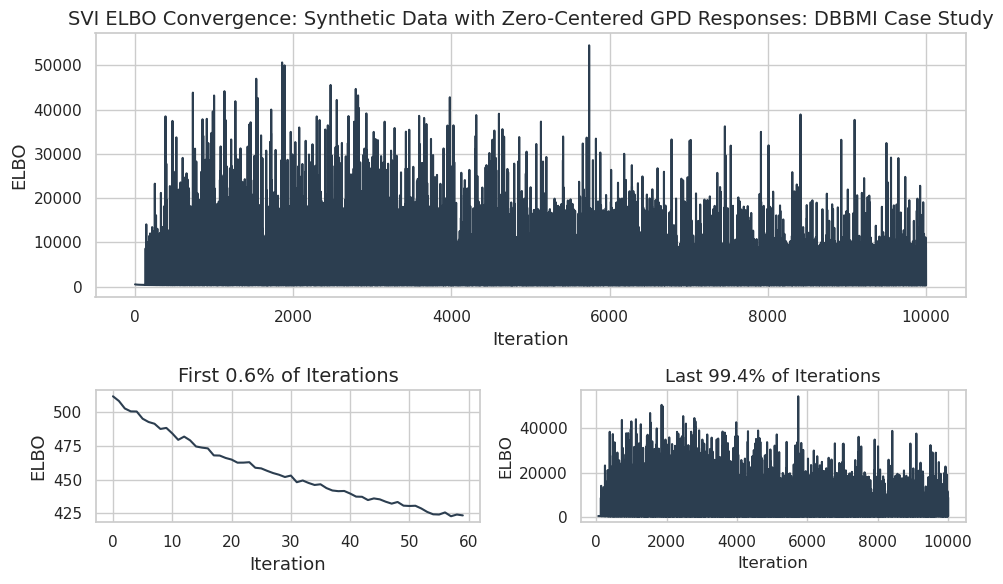

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/gpd/dbbmi_qq_plot.svg


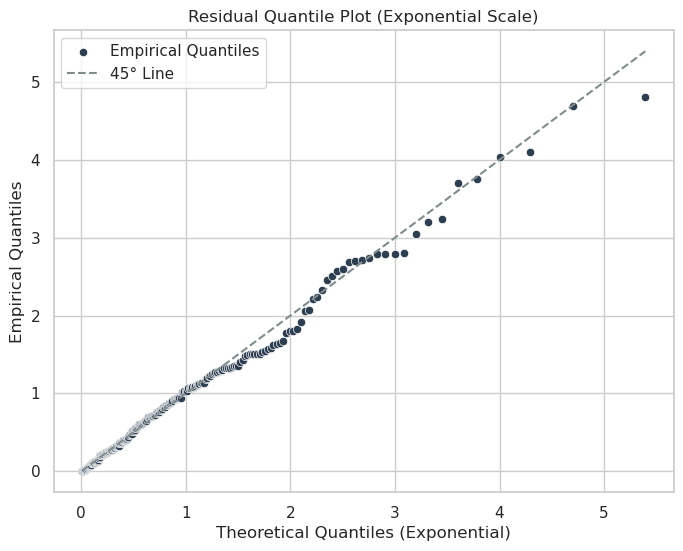

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/case_study/ald/case_study_cgpd_regression_results.svg


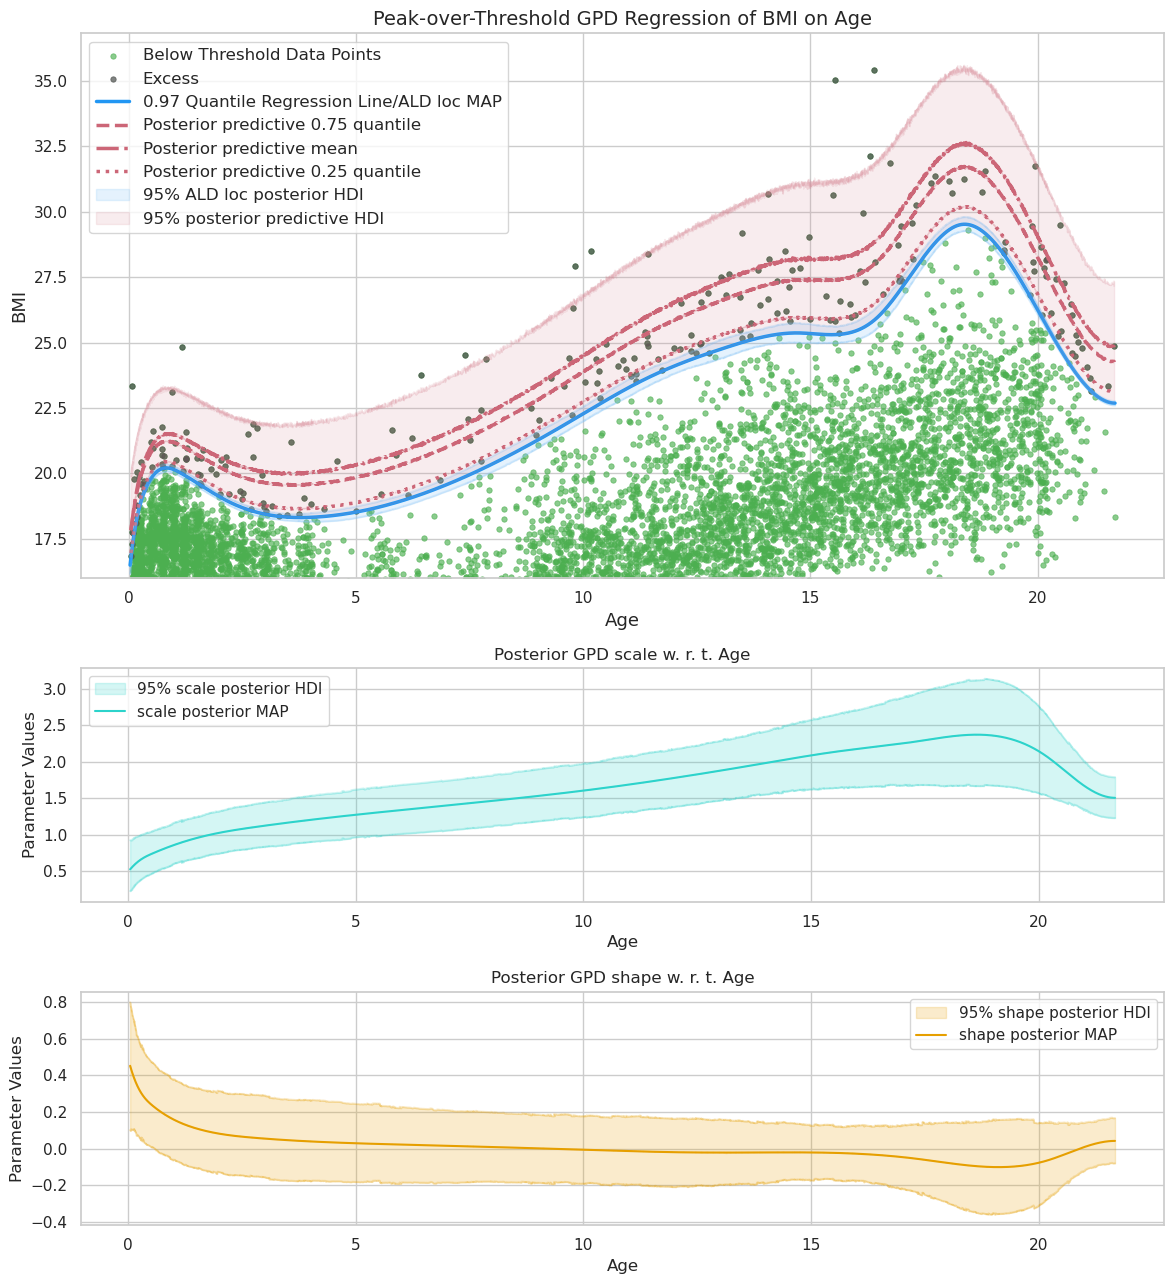

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/single_run_dbbi_data_prior_predictive_responses.svg


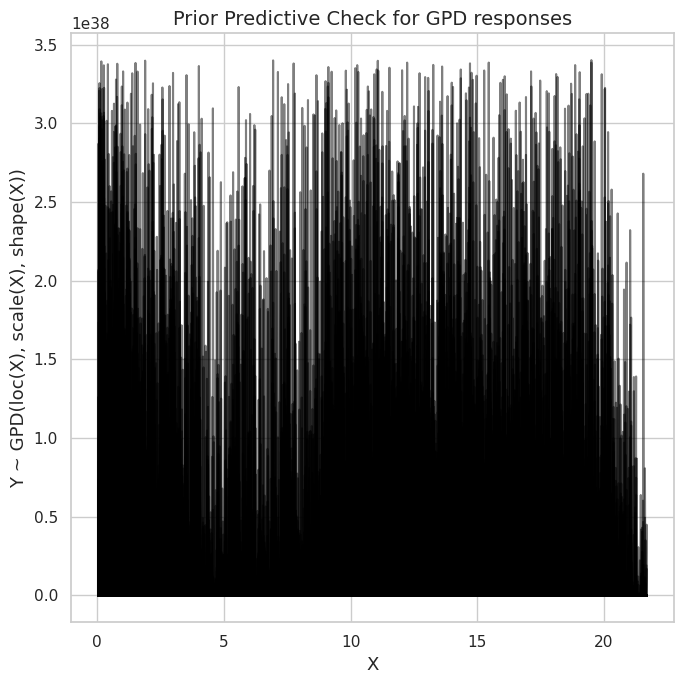

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/single_run_dbbi_data_prior_predictive_loc.svg


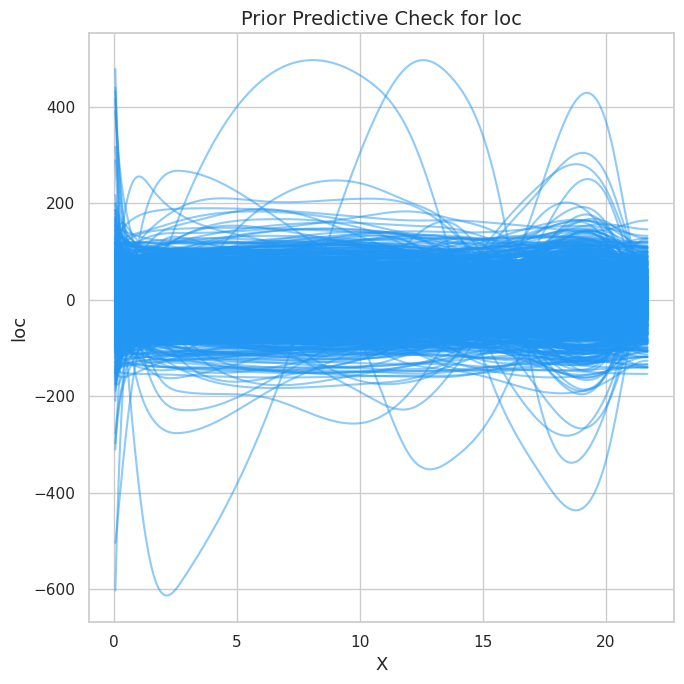

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/single_run_dbbi_data_prior_predictive_scale.svg


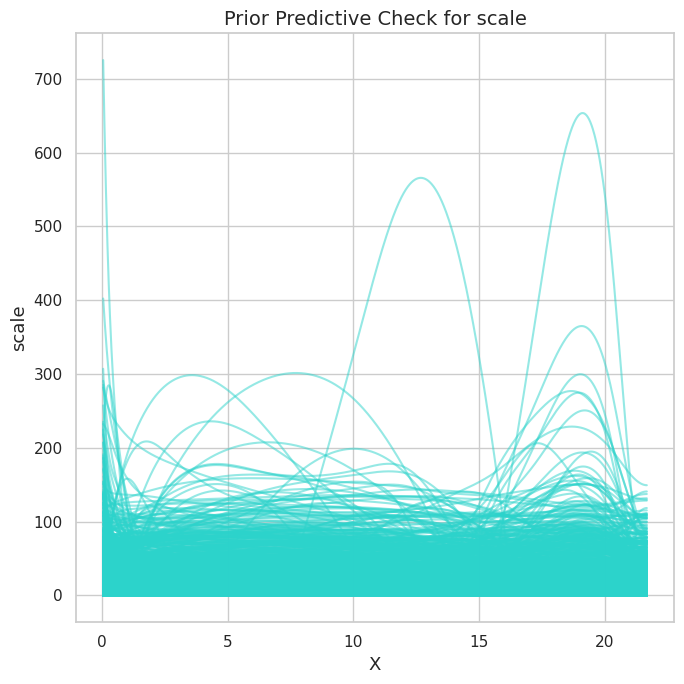

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/sim/single_run_dbbi_data_prior_predictive_shape.svg


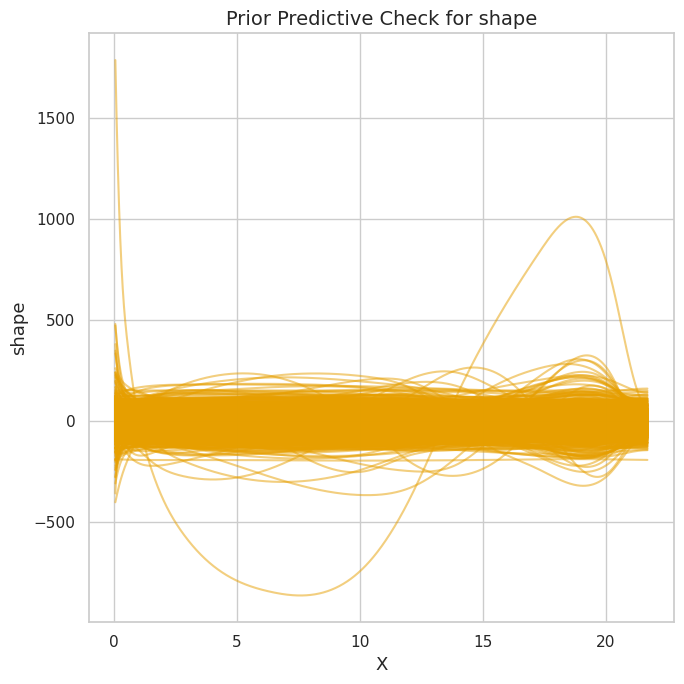

In [4]:
epochs_QR = 13000
epochs_GPD = 10000

DesignMatrixQR, X, Y, K_QR, knots_QR = vigamlss_dbbmi_prepare_qr_data()
model_QR, tau = vigamlss_dbbmi_qr_define_model(DesignMatrixQR, Y, K_QR)
results_QR = vigamlss_dbbmi_qr_opt_run(model_QR, epochs_QR)
(
    Y_excess,
    X_excess,
    excess_mask,
    posterior_X_sorted,
    mask_X,
    posterior_thresholds_map,
    posterior_threshold_hdi_lower,
    posterior_threshold_hdi_upper,
) = vigamlss_dbbmi_qr_results(results_QR, model_QR, knots_QR, X, Y, tau, save_flag=True)

DesignMatrixCGPD, K_excess, knots_CGPD = vigamlss_dbbmi_prepare_gpd_data(X_excess)
model_CGPD = vigamlss_dbbmi_cgpd_define_model(DesignMatrixCGPD, Y_excess, K_excess)
results_CGPD = vigamlss_dbbmi_cgpd_opt_run(model_CGPD, epochs_GPD)
vigamlss_dbbmi_cgpd_results(
    results_CGPD,
    model_CGPD,
    X,
    Y,
    X_excess,
    Y_excess,
    knots_CGPD,
    tau,
    excess_mask,
    posterior_X_sorted,
    mask_X,
    posterior_thresholds_map,
    posterior_threshold_hdi_lower,
    posterior_threshold_hdi_upper,
    save_flag=True,
)